# Forecasting Grocery Sales in Volatile Economies: The Impact of Holiday Effects and Oil Prices Using SARIMAX and Prophet Models

# Introduction

This project addresses the problem of forecasting grocery sales in an emerging economy where demand is shaped not only by recurring seasonality, but also by disruptive external factors. Specifically, the focus is on the case of Ecuador, using data from Corporación Favorita, a major retail chain with stores distributed across diverse regions of the country.

The central goal is to evaluate whether incorporating variables such as national holidays and oil prices into time series forecasting models leads to more accurate sales predictions. To do so, we implement and compare two statistical frameworks: SARIMAX, which allows for detailed modeling of temporal dependencies and exogenous inputs, and Prophet, a model designed to handle multiple seasonalities and irregular calendar effects.

This study is grounded in the belief that retail forecasting in volatile contexts requires more than just trend fitting it requires models that can adapt to real-world disruptions. These disruptions include policy driven holiday shifts, regional festivity patterns, and macroeconomic indicators like fuel costs, which in Ecuador influence consumer purchasing power directly. By modeling these effects explicitly, we aim to improve not only forecast performance, but also interpretability for stakeholders.

# Problem

Grocery retailers face daily decisions about how much inventory to purchase, especially for perishable items. Overestimating demand leads to waste and increased costs; underestimating it causes shortages and missed sales. In relatively stable environments, these decisions can be guided by past trends. However, in countries like Ecuador, where the economy is influenced by commodity prices and holiday calendars are often modified by government decree, traditional methods often fall short.

This project explores how demand fluctuates in response to external signals that are specific to the Ecuadorian context. We aim to capture not just general seasonality, but also the unique patterns that arise around regional holidays, economic shocks, and promotional campaigns. The dataset used for this purpose includes store-level sales from 2013 to 2017, along with external variables that reflect these disruptions.


# Hypothesis

**Null Hypothesis (H₀):** Grocery sales in Ecuador are not significantly affected by holidays or oil price changes.  

**Alternative Hypothesis (H₁):** There is a statistically significant effect of these variables on short-term sales dynamics.


# Analytical Questions

1. Does the dataset cover a complete range of calendar dates during the period of interest?

2. Which specific dates exhibit peak and low sales, and do they coincide with holidays or known events?

3. How do sales patterns shift before, during, and after public holidays?

4. Is there a measurable relationship between oil price fluctuations and daily sales volume?

5. Do promotion campaigns interact with holidays to amplify or mitigate demand spikes?

6. Are certain store types or cities more sensitive to external shocks?

7. Which model (SARIMAX or Prophet) provides more robust and interpretable results?

8. How does the inclusion of exogenous variables affect error metrics such as NWRMSLE, MAE, and RMSLE?


## Environment Setup

Before proceeding with data loading and modeling, we must ensure that the required Python packages are installed and properly configured. These packages cover a variety of tasks, including data handling, time series modeling, visualization, and evaluation metrics.

For this project, we focus primarily on interpretable forecasting using SARIMAX and Prophet. However, we also import some tools commonly used in time series preprocessing and diagnostic analysis.

> Note: The following cell lists the installation commands. In many environments (e.g., Google Colab or Jupyter), these can be executed with `!pip install` or `%pip install` if any of the libraries are missing.


In [5]:
# Uncomment and run this cell if packages are not yet installed
# %pip install pandas numpy matplotlib seaborn
# %pip install statsmodels scikit-learn scipy pmdarima
# %pip install prophet

In [4]:
# Installations

%pip install pyodbc
%pip install python-dotenv
%pip install sqlalchemy
%pip install lightgbm
%pip install xgboost
%pip install catboost
%pip install pmdarima


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Importing Required Libraries

We now import the necessary libraries, grouped by functionality.

In [6]:
# Core Libraries for Data Handling
import pandas as pd         # For structured data manipulation
import numpy as np          # For numerical operations and arrays

# Visualization Tools
import matplotlib.pyplot as plt       # For general-purpose plotting
import matplotlib.dates as mdates     # For formatting time axes
import seaborn as sns                 # For statistical data visualizations

# Time Series Decomposition and Testing
from statsmodels.tsa.seasonal import seasonal_decompose   # Decomposes series into trend, seasonality, and residuals
from statsmodels.tsa.stattools import adfuller            # Augmented Dickey-Fuller test for stationarity

# Modeling Libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX    # Core SARIMAX model used in this project
from prophet import Prophet                               # Meta’s Prophet model for seasonality-aware forecasting

# Comparative Traditional Models (for baseline or EDA)
from sklearn.linear_model import LinearRegression          # Simple linear model (not core to our goal, but useful for benchmarking)

# Preprocessing Tools
from sklearn.preprocessing import MinMaxScaler             # For normalizing numerical data
from sklearn.preprocessing import OneHotEncoder            # For encoding categorical features if needed

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    mean_squared_log_error, make_scorer
)

# Statistical Testing
from scipy import stats                                    # For hypothesis testing (e.g., t-test)

# Miscellaneous Utilities
import os              # For working with the file system
import pickle          # For saving/loading trained models
import zipfile         # For compressing model artifacts
import warnings        # To suppress warnings in notebook output

warnings.filterwarnings('ignore')


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plotting Configuration

To ensure visual consistency and clarity throughout the notebook, we define a global configuration for matplotlib and seaborn. 

In [7]:
# Aesthetic configuration for plots
plt.style.use("seaborn-v0_8")

plt.rcParams.update({
    "figure.autolayout": True,
    "figure.figsize": (11, 4),
    "figure.titlesize": 18,
    "figure.titleweight": 'bold',
    "axes.labelweight": "bold",
    "axes.labelsize": "large",
    "axes.titleweight": "bold",
    "axes.titlesize": 16,
    "axes.titlepad": 10,
})

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Display figures in retina resolution (useful for notebooks)
%config InlineBackend.figure_format = 'retina'


# Data Understanding

### Accessing and loading the datasets

To begin the analysis, several key datasets were placed directly in the working directory (D:\Archivos de Usuario\Documents\Time Series Forecasting). These include information about holidays (holiday.csv), oil prices (oil.csv), and store metadata (stores.csv). These files were not retrieved from an external database but were made locally available to streamline the development process.

First, we proceed by loading each dataset using pandas and removing redundant index columns created during previous export operations.

In [8]:
import pandas as pd

# Load the datasets
holiday = pd.read_csv("holiday.csv")
oil = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")

# Drop unnecessary index columns if present
for df in [holiday, oil, stores]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)


## Data Access and Repository Cloning

To work with the full dataset required for this forecasting project, we cloned the public GitHub repository where the original files are hosted. This repository includes large CSV files such as `train.csv`, `test.csv`, `transactions.csv`, and `sample_submission.csv`, which are necessaries for training and evaluating the models.

This step also ensures reproducibility, as all the source files are versioned and documented in the repository maintained by the original author.

The repository was cloned using the following command:

In [9]:
# Clone the repository with full dataset
!git clone https://github.com/iameberedavid/Time-Series-Forecasting-Analysis-For-Corporation-Favorita.git

Cloning into 'Time-Series-Forecasting-Analysis-For-Corporation-Favorita'...
Filtering content:  40% (2/5)
Filtering content:  60% (3/5), 1.30 MiB | 1.73 MiB/s
Filtering content:  80% (4/5), 1.30 MiB | 1.73 MiB/s
Filtering content: 100% (5/5), 118.94 MiB | 2.78 MiB/s
Filtering content: 100% (5/5), 637.68 MiB | 5.27 MiB/s
Filtering content: 100% (5/5), 637.68 MiB | 5.21 MiB/s, done.


Once the repository is cloned, the required CSV files can be accessed by specifying the correct relative path. The datasets are located inside the main project folder `Time-Series-Forecasting-Analysis-For-Corporation-Favorita/`.


In [ ]:
# Define base path to the cloned repository
base_path = 'Time-Series-Forecasting-Analysis-For-Corporation-Favorita/'

# Load datasets
train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')
transactions = pd.read_csv(base_path + 'transactions.csv')
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')


After this point, we are ready to begin exploratory data analysis and preprocessing with the full dataset.


### EDA

In [11]:
# Load the first five rows of the holiday dataset

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
# Identify the unique features of the 'type' column

holiday['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

The holidays whose type are designated as 'Transfer' are the holidays that occured on a particalar date but were observed on a different date. These holidays officially fall on the specified calendar date but were moved to another date by the government. This could be because the holidays occured in a weekend, or for any other reason. Since we are interested in the store sales performance on the actual days that holidays were observed, the holidays with type as 'Trasfer' will be isolated, and their holiday date changed to the actual date each holiday was observed.

In [13]:
# Filter holidays with 'type' as 'Transfer'
transferred_holidays = holiday[holiday['type'] == 'Transfer']

# Display the holidays with 'type' as 'Transfer'
transferred_holidays

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [14]:
# Function to change the date of transferred holidays to the date the holidays were observed
def change_transferred_holidays_date(row):
    if row['type'] == 'Transfer':
        corresponding_row = holiday[(holiday['description'] == row['description']) & 
                                               (holiday['type'] != 'Transfer') & 
                                               (holiday['date'] != row['date'])]
        if not corresponding_row.empty:
            return corresponding_row.iloc[0]['date']
    return row['date']

# Apply the function to change the date of transferred holidays to the date the holidays were observed
holiday['date'] = holiday.apply(change_transferred_holidays_date, axis=1)

# Drop any duplicate rows created
holiday.drop_duplicates(inplace=True)

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
# Load the first five rows of the stores dataset

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [21]:
print(stores.head())

   store_nbr           city                           state type cluster
0          1          Quito                       Pichincha    D      13
1          2          Quito                       Pichincha    D      13
2          3          Quito                       Pichincha    D       8
3          4          Quito                       Pichincha    D       9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D       4


In [22]:
# Check the datatypes of the columns in stores dataset

stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

In [23]:
# Change the datatypes of the columns (except 'store_nbr') in stores dataset to category for consistency and ease in handling the dataset
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['type'] = stores['type'].astype('category')
stores['cluster'] = stores['cluster'].astype('category')

# Verify the changes
stores.dtypes

store_nbr       int64
city         category
state        category
type         category
cluster      category
dtype: object

In [18]:
# Load the first five rows of the oil dataset

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [19]:
# Load the first five rows of the transactions dataset

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [24]:
# Load the first five rows of the train dataset

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [25]:
# Load the first five rows of the test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [26]:
# Load the first five rows of the sample_submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [27]:
# Create a dictionary of the datasets

data = {'holiday': holiday, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train, 'test': test, 'sample_submission': sample_submission}

In [28]:
# Check the datatypes and presence of missing values in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')

For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), int64(1)
memory usa

In [29]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')

For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________


For test dataset
Shape: (28512, 5)
Missing values = 0
Duplicates = 0
______________________________


For sample_submission dataset
Shape: (28512, 2)
Missing values = 0
Duplicates = 0
______________________________




# Problems Identified

The datasets are seperate, and need to be merged together for better analysis.

The oil dataset has 43 missing values on the 'dcoilwtico' column. This will be filled after merging the datasets. This column represents the oil price in Ecuador during the time period the data was gathered. The column name will be changed to 'oil_price' for easier identification and understanding of it's features.

There is no column to precisely identify the days in which there were holidays and days in which there were no holidays. This column will be created after merging and named 'holiday_status' as it will be important for our analysis.

The 'date' columns of each dataset have an object datatype. This will be changed to datetime datatype after merging.

# Data Preparation

The problems identified with the datasets will be handled in preparation for analysis and modelling.

### Merge the datasets based on common columns

In [30]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holiday, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [31]:
# Check for missing values after merging the datasets

df4.isna().sum().sum()

13972299

There are dates with values on a dataset that are not represented at all on another dataset. When these datasets are merged, the rows of such dates will have missing values. This is one of the reasons for the huge amount of missing values in the merged dataset. Another reason is that the oil dataset has some missing values of it's own which were introduced to the merged dataset. These missing values will be filled subsequently.

In [32]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

0

In [33]:
# Create a copy of the merged dataset for further exploration

df = df4.copy()

In [34]:
# Drop the 'id' column as it is unnecessary

df.drop(columns=['id'], inplace=True)

In [35]:
# Identify the features of 'type_x' column in the merged dataset

df['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

Observe that the features of this column are same with the 'type' column of the holiday dataset. This column will be renamed to 'holiday_type' for easier identification. Also observe that there are missing values in this column as revealed by the presence of 'nan'. This will be handled while handling missing values subsequenty.

In [36]:
# Identify the features of 'type_y' column in the merged dataset

df['type_y'].unique()

['D', 'C', 'B', 'E', 'A']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']

Observe that the features of this column are same with the 'type' column of the store dataset. This column will be renamed to 'store_type' for easier identification.

In [37]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df = df.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y': 'store_type'})
df.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


### Filling missing values

In [38]:
# Identify the columns with missing values

df.isna().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

The missing values in the transactions column will be filled with 0 because it represents the absence of transactions on those days.

In [39]:
# Fill the missing values in the transactions column with 0

df['transactions'].fillna(0, inplace=True)
df.isna().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type    2553606
locale          2553606
locale_name     2553606
description     2553606
transferred     2553606
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

For holiday_type, locale, locale_name, description and transferred columns, there are equal number of missing values. This is because these columns are from the holiday dataset, and they represent the days where there were no holidays. These empty cells will be filled with 'No holiday' for easy identification.

In [40]:
# Fill the missing values in type_x, locale, locale_name, description and transferred columns with 'No holiday'
columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df[column].fillna('No holiday', inplace=True)

# Confirm that there are no more missing values in these columns
df.isna().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

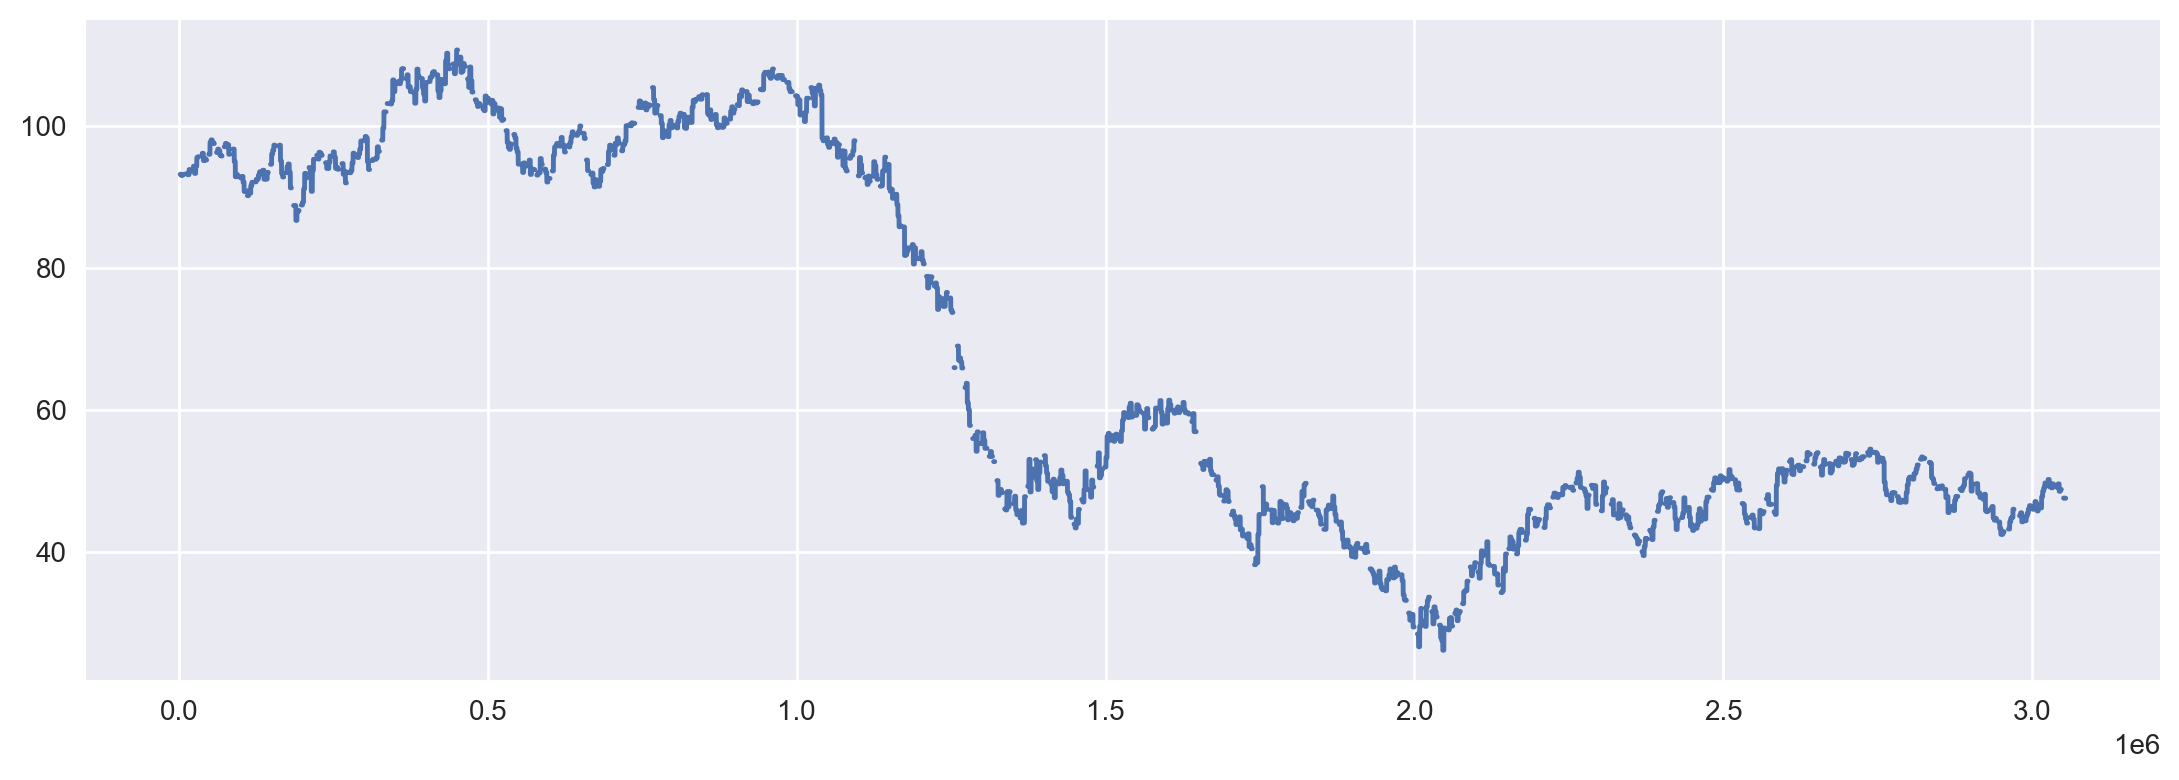

In [41]:
# Visualize the trend of oil prices before filling the missing values in the 'oil_price' column

df['oil_price'].plot()

The chart above reveals that there is a trend formed as the oil price changes. For this reason, the missing values in the 'oil_price' column will be filled using backward fill to ensure continuity in the trend.

<Axes: >

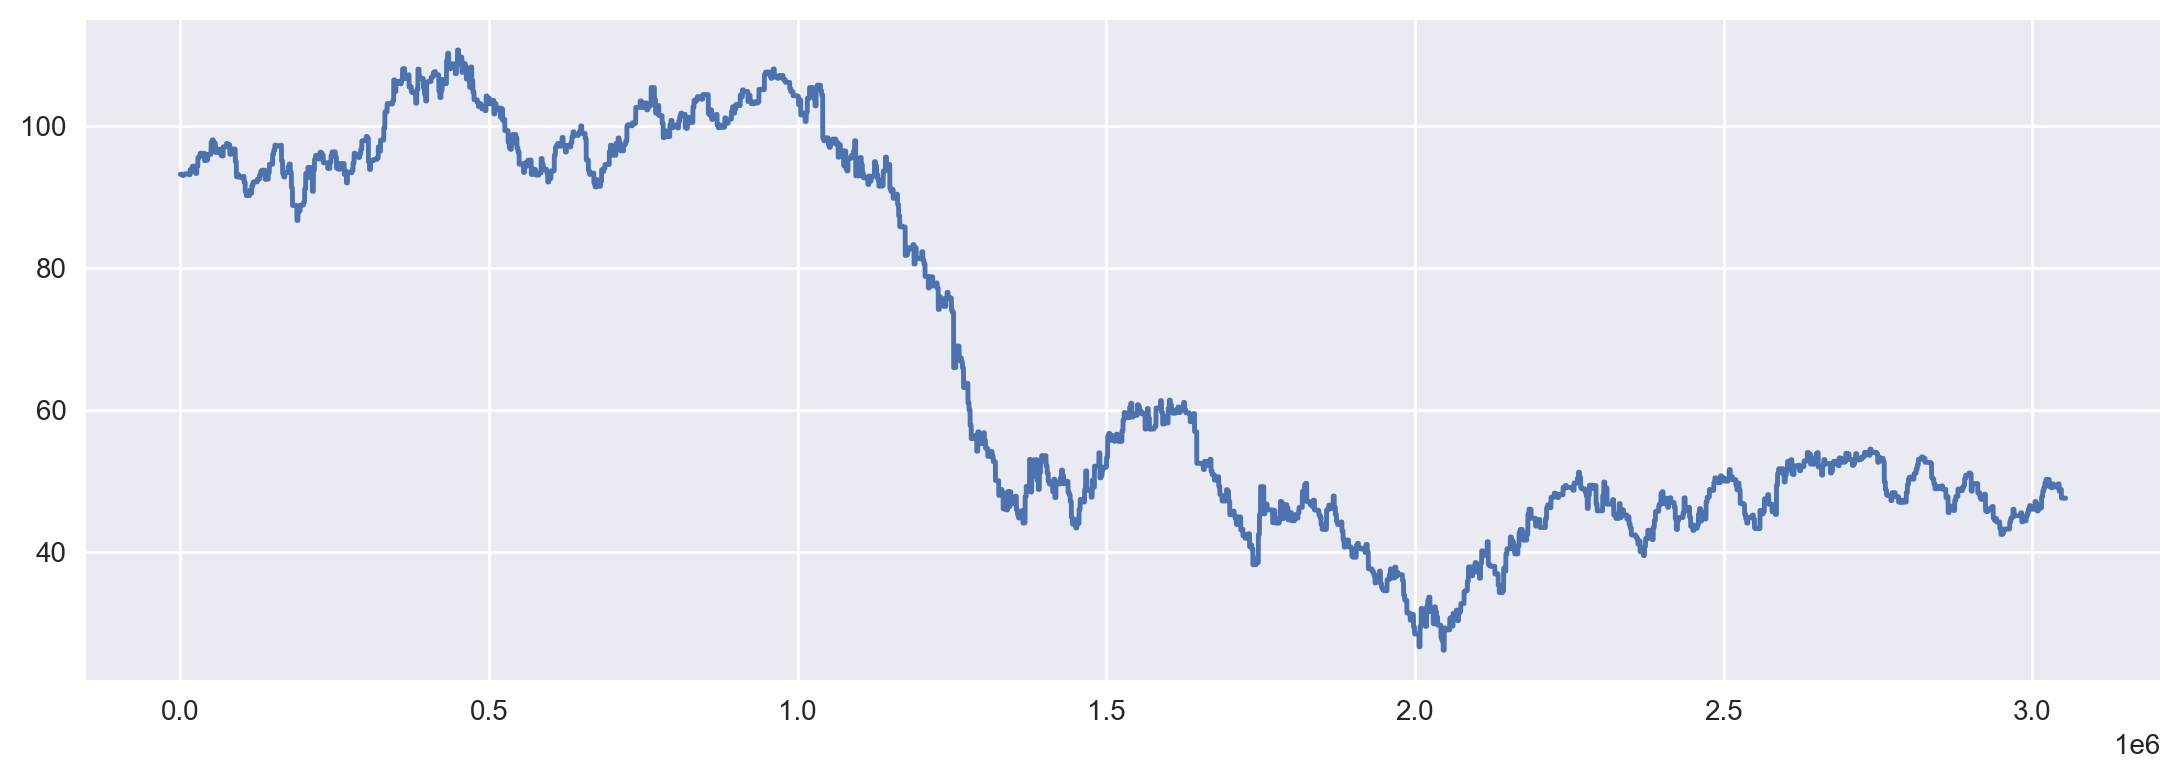

In [42]:
# Fill the missing values in the 'oil_price' column using backward fill
df['oil_price'].fillna(method='bfill', inplace=True)

# Visualize the trend of oil prices after filling the missing values
df['oil_price'].plot()

In [43]:
# Confirm that there are no more missing values in the merged dataset

df.isna().sum().sum()

0

As shown above, the continuity of the trend was maintained after filling the missing values in the 'oil_price' column.

### Create the 'holiday_status' column

In [44]:
# Check the unique values of the 'holiday_type' column

df['holiday_type'].unique()

array(['Holiday', 'No holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

In [45]:
# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df['holiday_status'] = df['holiday_type'].apply(map_holiday_status)
df.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [46]:
# Check the unique values of the 'holiday_status' column

df['holiday_status'].unique()

array(['Holiday', 'No holiday'], dtype=object)

### Change the datatype of the 'date' column from object to datetime and extract date features

In [47]:
# Change the datatype of the date column to datetime
df['date'] = pd.to_datetime(df['date'])

df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3054348 entries, 0 to 3054347
Series name: date
Non-Null Count    Dtype         
--------------    -----         
3054348 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.3 MB


In [48]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['dayname'] = df.date.dt.strftime('%A')

df.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


In [49]:
# Set the 'date' column as index

df = df.set_index('date')
df.head()

,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday
2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,...,Quito,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday


In [50]:
# Rename df to train_data

train_data = df.copy()

In [51]:
# Display random sample of 8 rows

train_data.sample(8, random_state = 42)

,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,...,city,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2014-01-07,23,DAIRY,471.000,0,1135.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Ambato,Tungurahua,D,9,No holiday,2014,1,7,1,Tuesday
2014-12-05,1,BEAUTY,1.000,0,2028.0,Additional,Local,Quito,Fundacion de Quito-1,False,...,Quito,Pichincha,D,13,Holiday,2014,12,5,4,Friday
2014-07-06,45,HOME APPLIANCES,0.000,0,4626.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,7,6,6,Sunday
2014-05-02,20,LAWN AND GARDEN,0.000,0,0.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,B,6,No holiday,2014,5,2,4,Friday
2014-02-25,25,HOME AND KITCHEN II,0.000,0,705.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Salinas,Santa Elena,D,1,No holiday,2014,2,25,1,Tuesday
2014-01-26,49,PRODUCE,7866.909,0,2744.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,1,26,6,Sunday
2014-11-23,49,GROCERY II,107.000,0,3096.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Quito,Pichincha,A,11,No holiday,2014,11,23,6,Sunday
2013-08-24,20,PRODUCE,0.000,0,0.0,Holiday,Local,Ambato,Fundacion de Ambato,False,...,Quito,Pichincha,B,6,Holiday,2013,8,24,5,Saturday


# Visualizations

Text(0.5, 0, 'Year')

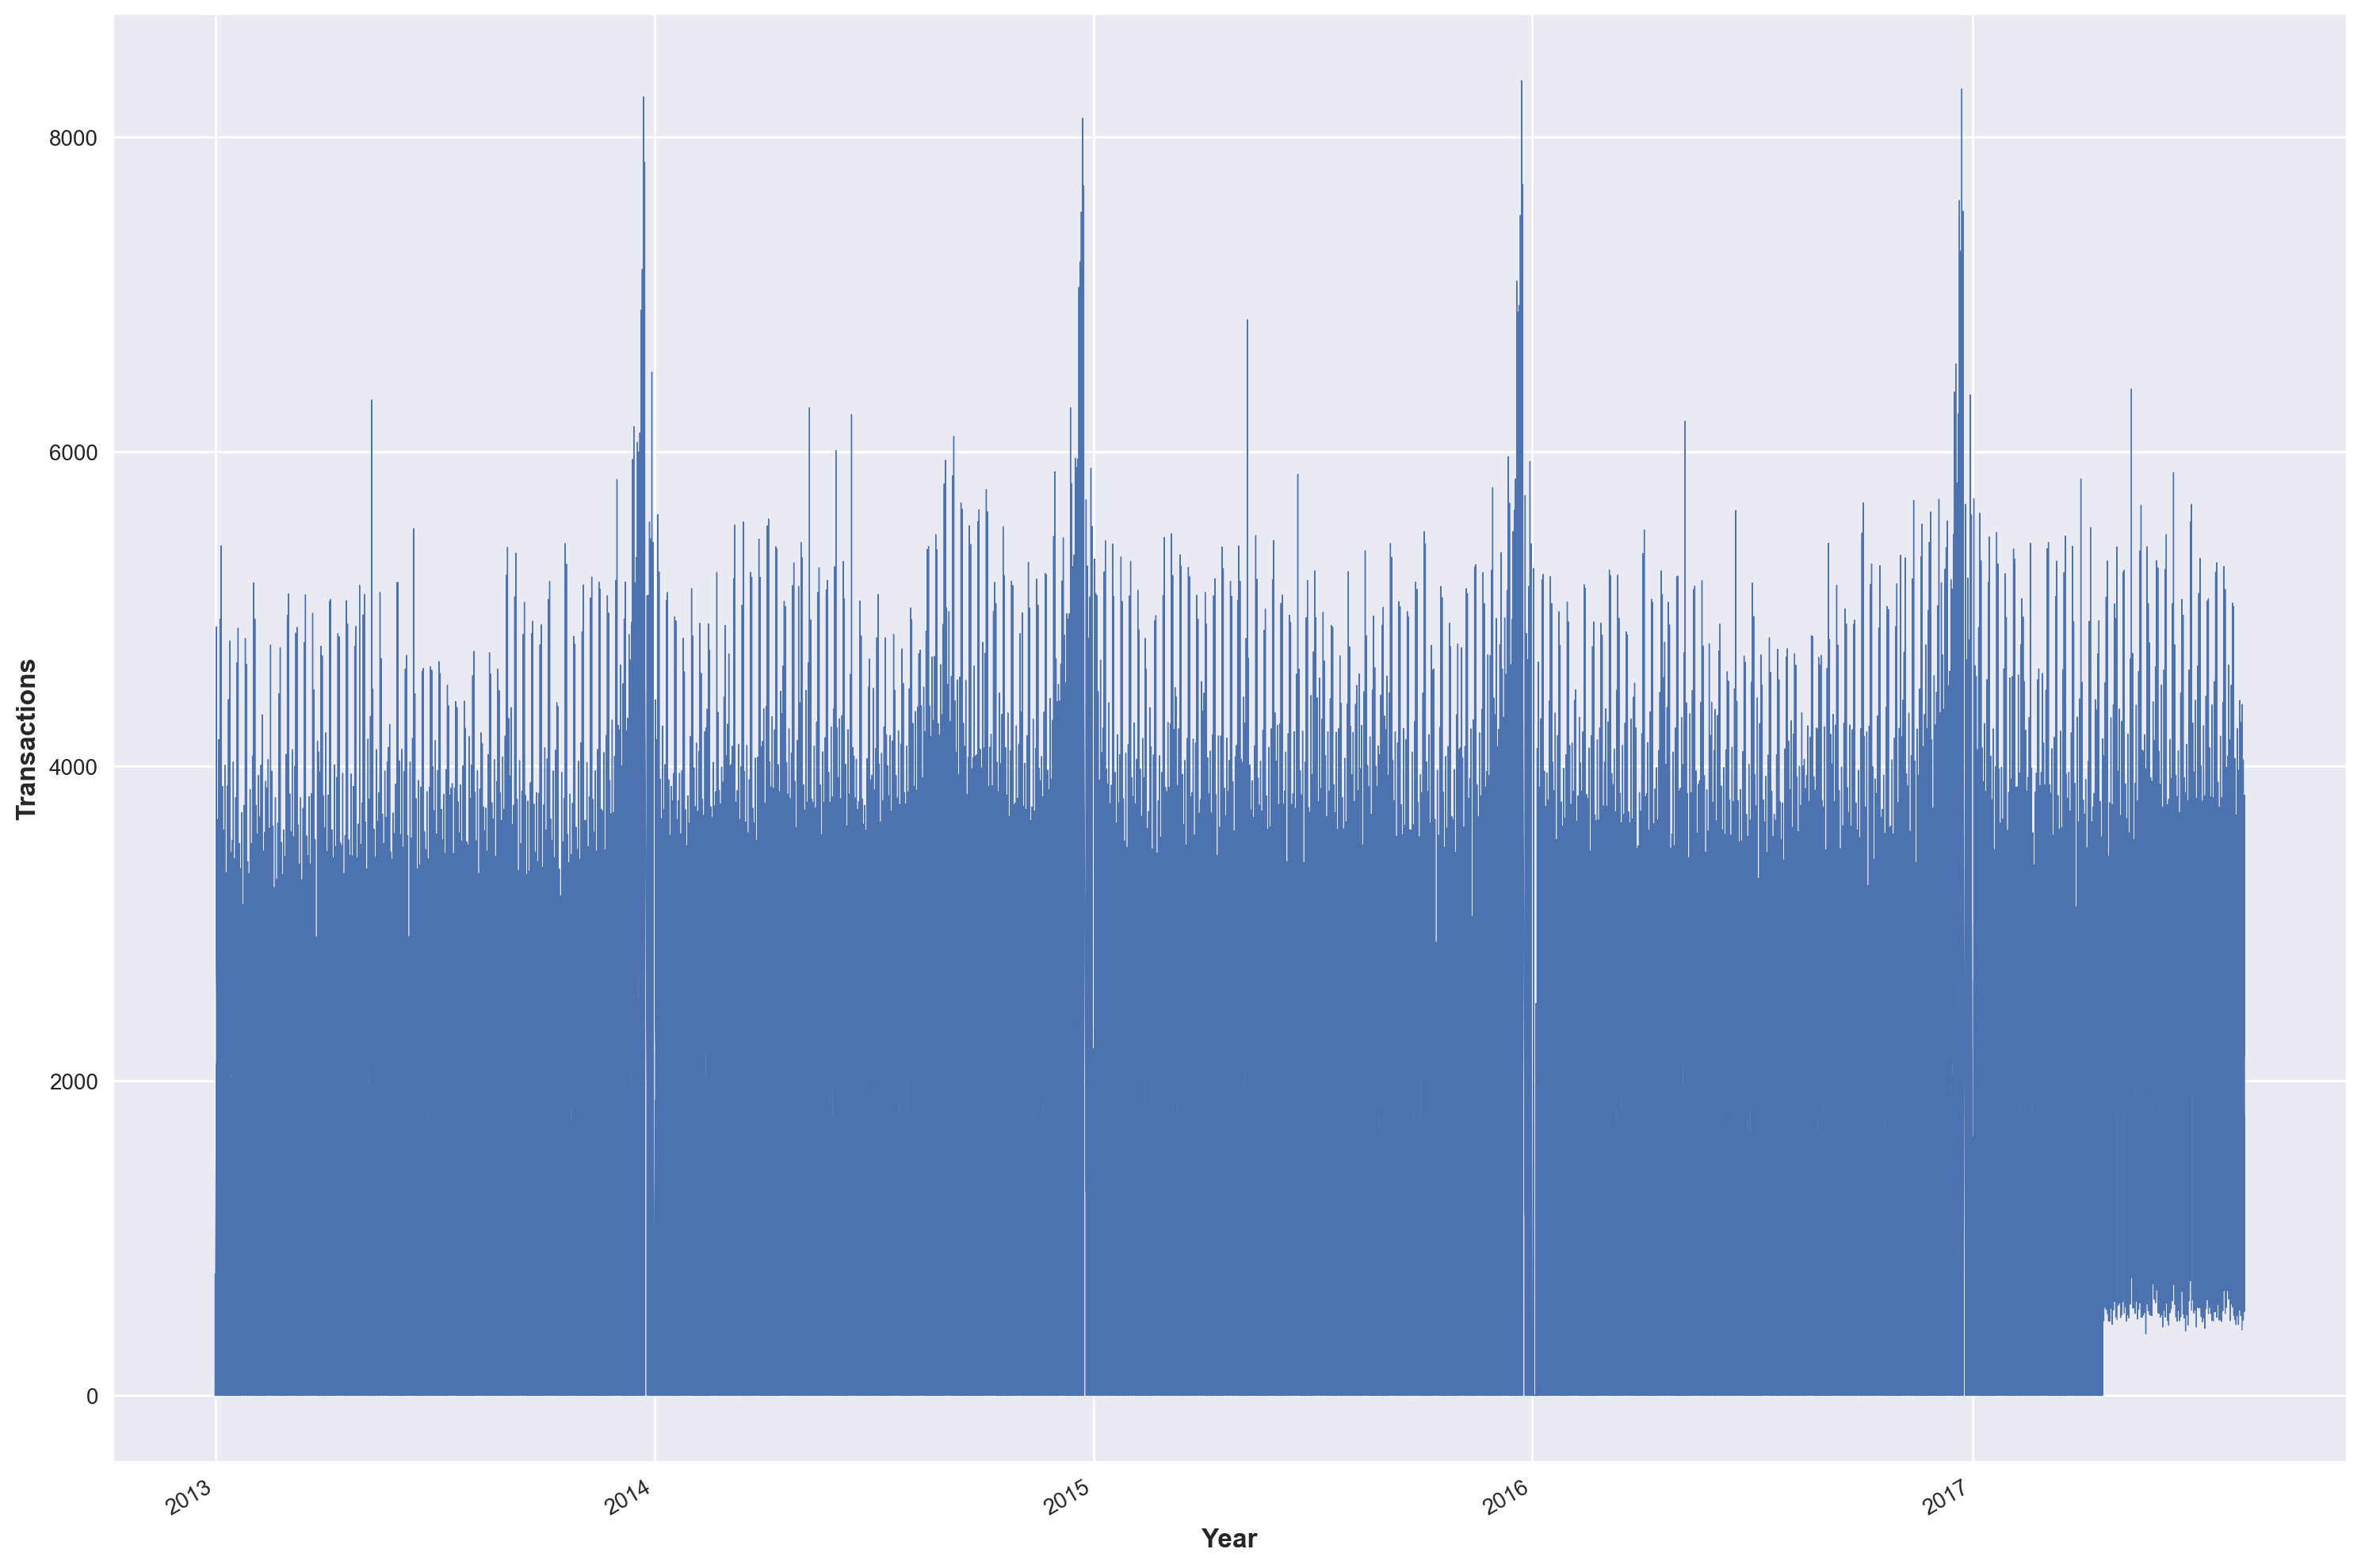

In [53]:
# Visualize the 'transactions' column

plt.figure(figsize=(15,10))
ax = train_data['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The plot above reveals that transactions are always highest at the end of each year. This reveals seasonality in the dataset.

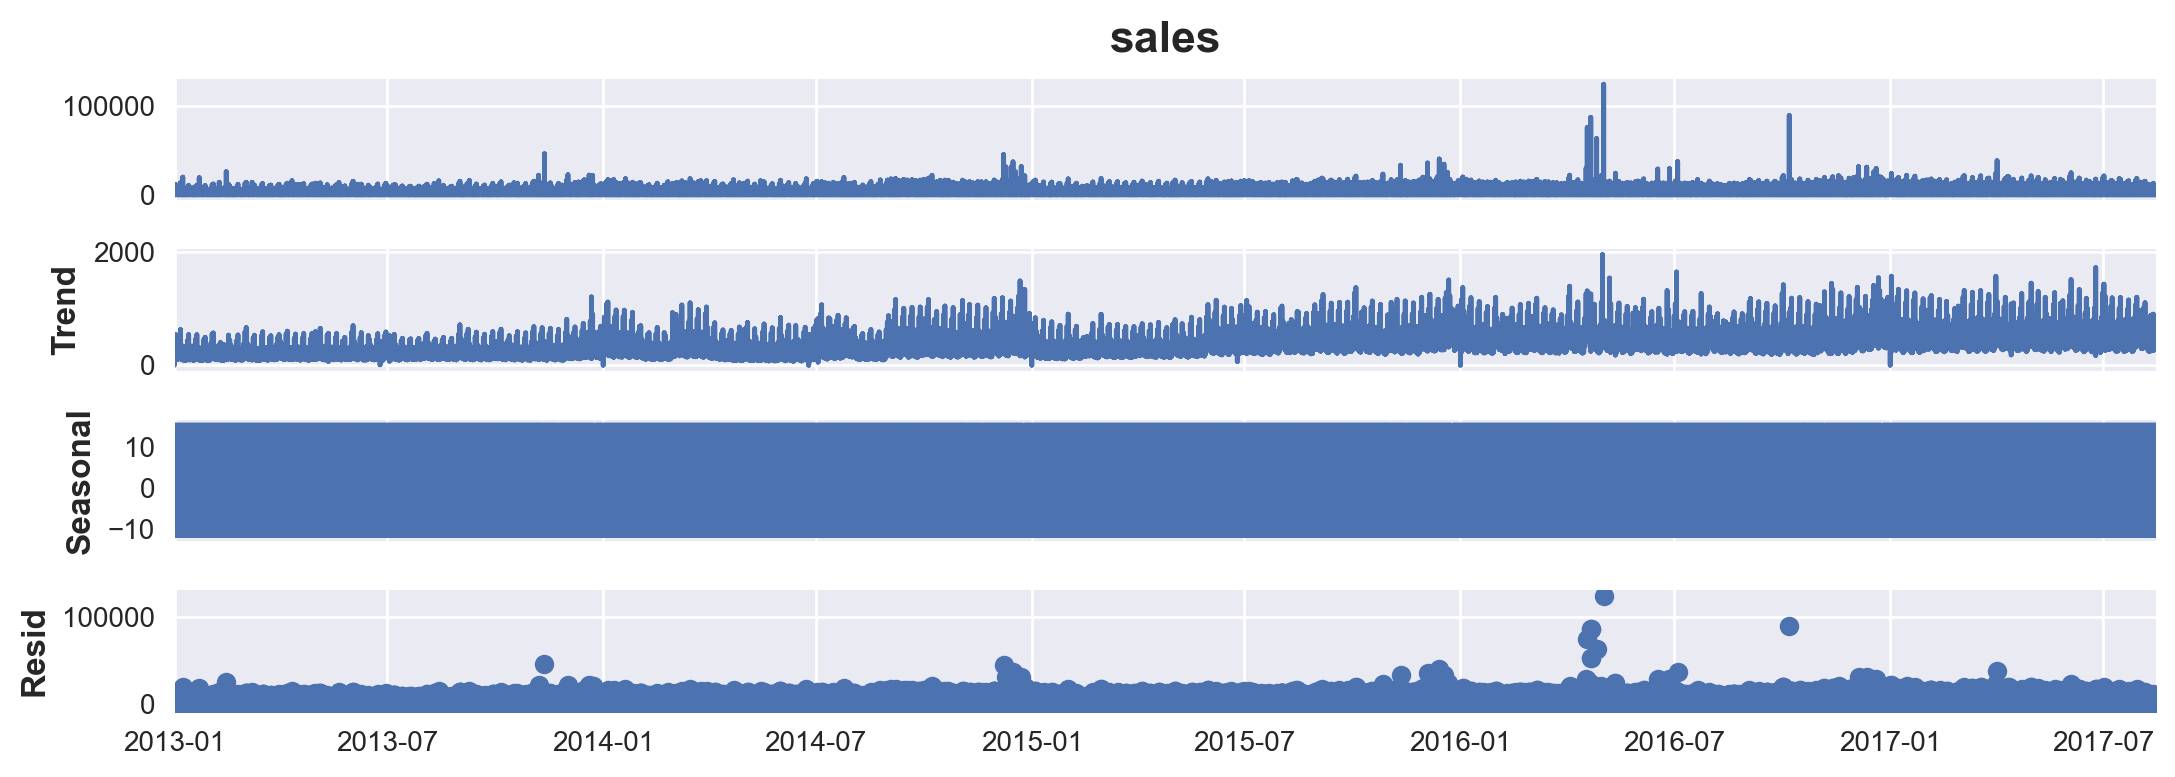

In [54]:
# Perform seasonal decomposition

result = seasonal_decompose(train_data['sales'], model='additive', period=365)
result.plot()
plt.show()

Seasonal decomposition is a technique used in time series analysis to gain a better understanding of the underlying structure and patterns within the time series dataset by breaking down the dataset into its constituent components, which are typically the following:

**Trend Component:** This component represents the long-term movement or direction in the data. It captures the underlying pattern in the data that persists over time. For example, in a retail sales time series, the trend component might represent the overall growth or decline in sales over multiple years. For our dataset, the trend component shows an overall growth in sales over the years as there is a generally upward trending pattern in sales. 

**Seasonal Component:** The seasonal component captures the repeating patterns or fluctuations in the data that occur at fixed intervals, such as daily, weekly, monthly, or yearly. These patterns are often associated with external factors like seasons, holidays, or other recurring events. For our dataset, the fully colored seasonal component indicates prominent recurring patterns at fixed intervals, likely due to seasonal factors influencing sales.

**Residual Component (or Error):** The residual component represents the unexplained or random variations (noise or irregularities) in the data after removing the trend and seasonal components. For our dataset, the residual component shows less random behavior.

##### Performing seasonal decomposition serves several important purposes:

***Pattern Identification:*** Decomposition helps identify and isolate the underlying patterns, trends, and seasonal effects in the data. This information can be valuable for making predictions and informed decisions.

***Anomaly Detection:*** Separating out the trend and seasonal components makes it easier to identify and detect unusual or anomalous behavior in the data. Any deviations from the expected pattern can be more readily spotted in the residual component.

***Forecasting:*** Once the time series is decomposed, you can model and forecast each component separately. This allows for more accurate and interpretable predictions. For example, you can forecast the trend and seasonality separately and then combine them to make a final prediction.

***Data Analysis and Visualization:*** Decomposition provides a cleaner and clearer way to visualize and analyze the individual components, making it easier to communicate the insights to stakeholders.

***Modeling:*** Many time series forecasting models (example ARIMA or Exponential Smoothing models) work more effectively when applied to the individual components, potentially leading to better modelling results.


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

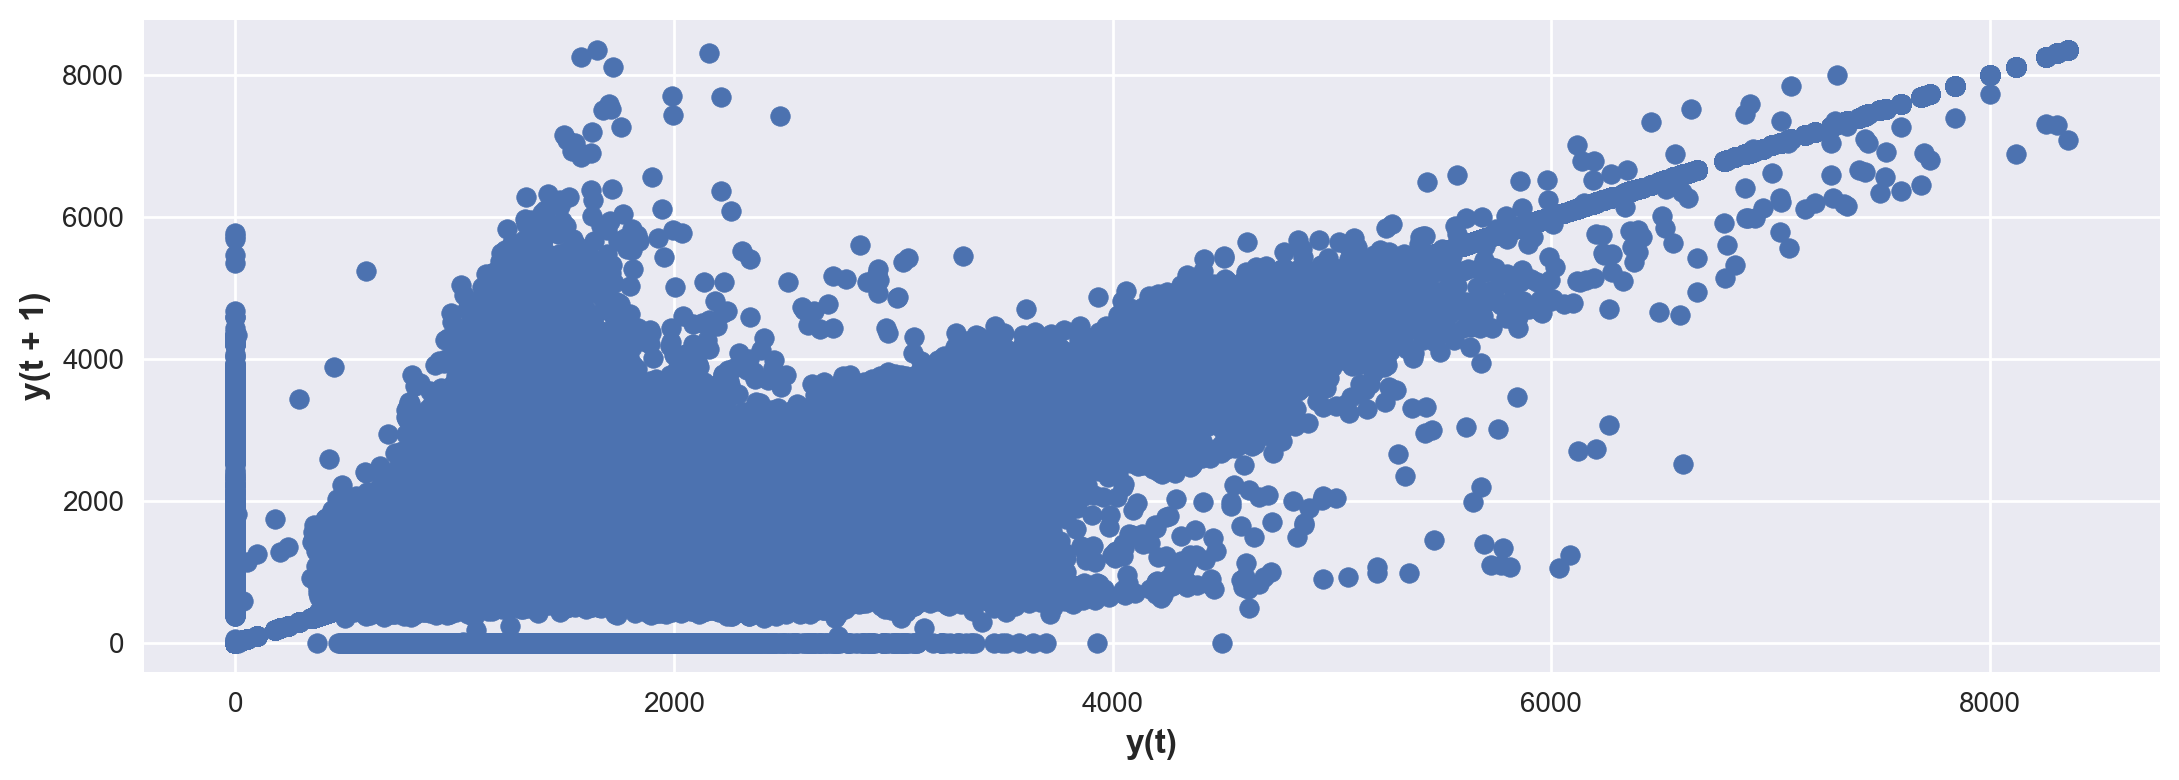

In [55]:
# Create a lag plot

pd.plotting.lag_plot(train_data['transactions'], lag=1)

A lag plot is a graphical tool used in time series analysis to examine the autocorrelation or serial correlation in a dataset. Autocorrelation refers to the correlation between a time series and a lagged version of itself, which can provide valuable insights into the underlying structure of the data. The lag plot helps in visualizing autocorrelation, identifying seasonality, assessing stationarity, model selection, detecting serial correlation, and checking residuals.

The lag plot above for our dataset reveals that there is clustering, linearity, and a few pattern deviations in the plot.

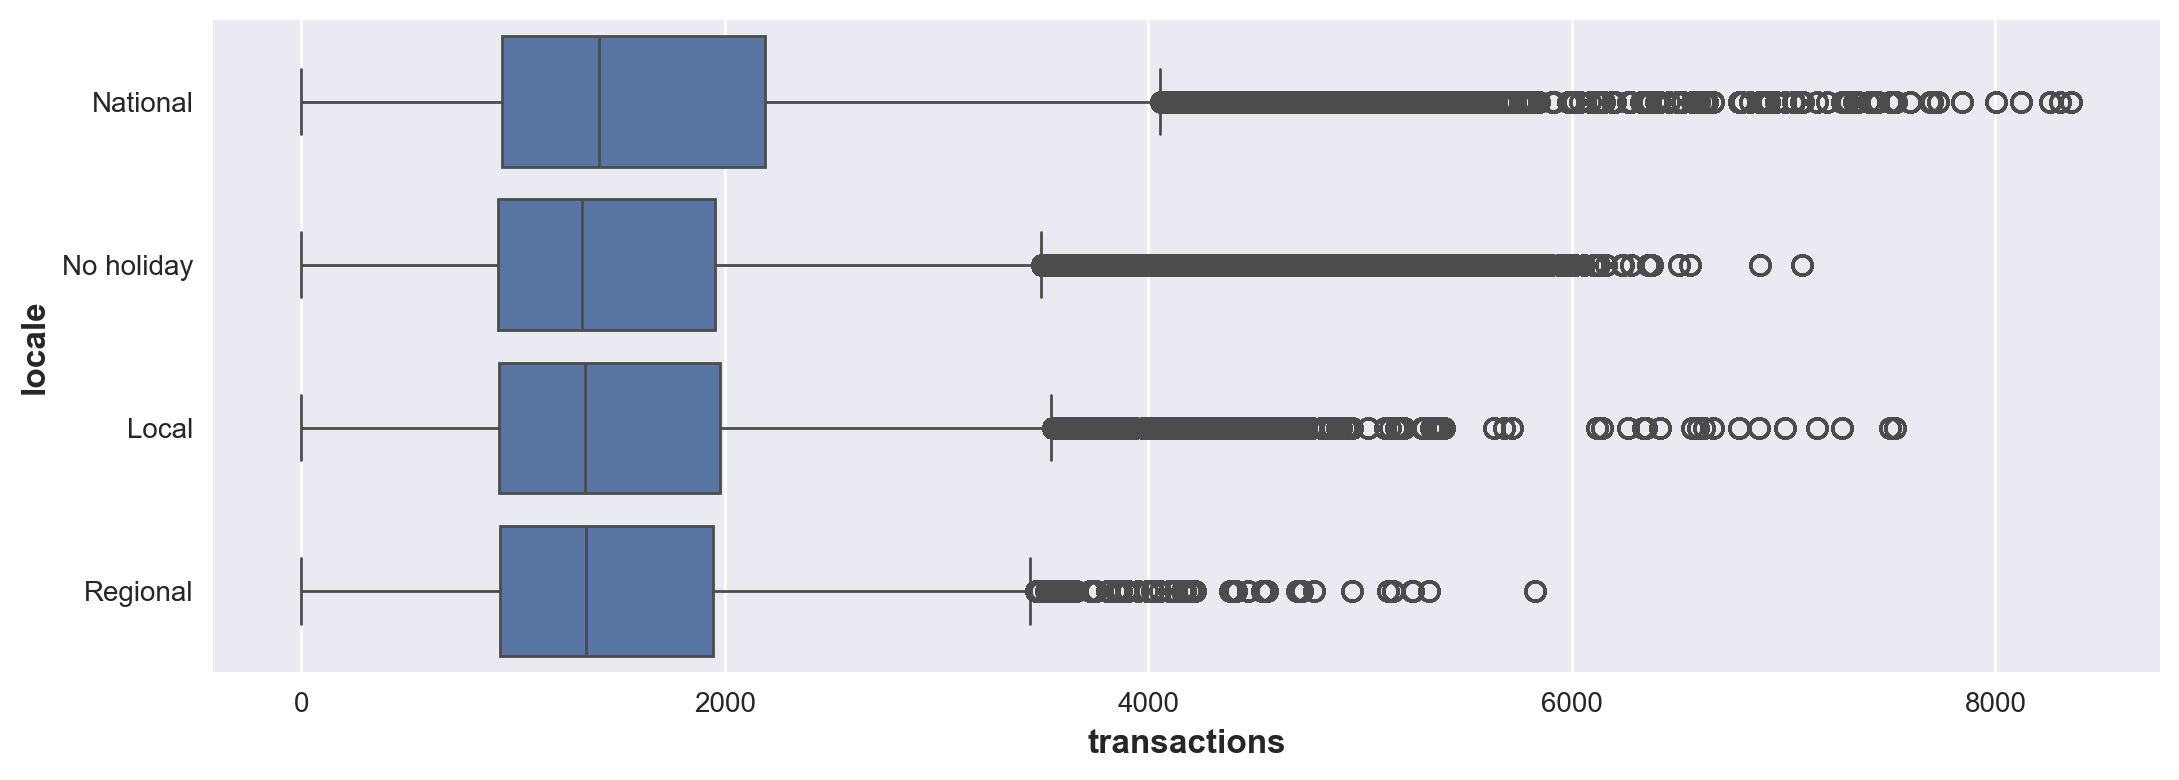

In [56]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=train_data)

# Show the plot
plt.show()

For the box plot above, the median (the line within the box) shows the central tendency of the data and is highest for 'National holidays'. Also, the length of the boxes show that 'transactions' on National Holidays have the greatest variability as it has the longest box. The data points that fall outside the whiskers of all the boxes indicate extreme values (outliers) or anomalies  with 'National holidays' having the most extreme values.

Based on the boxplot, there is evidence of significant variations in transaction patterns between locales.

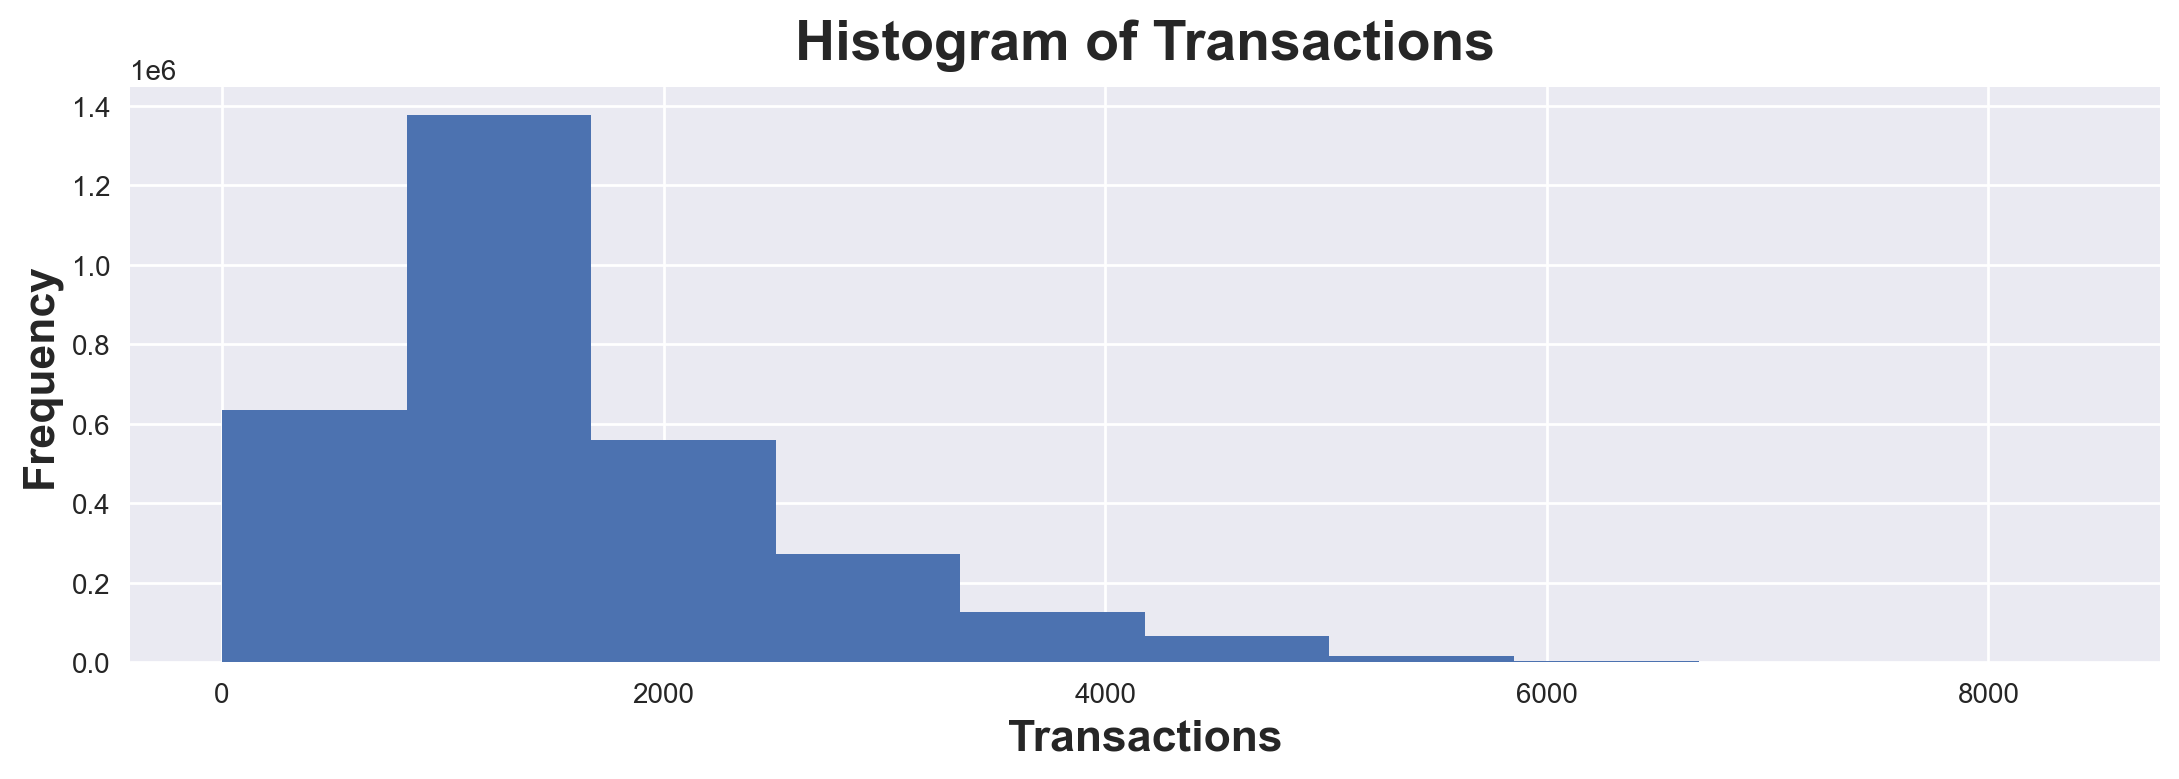

In [57]:
# Create a histogram of the 'transactions' column
train_data.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot
plt.show()

The histogram suggests that most transactions fall within a certain range, around 800 to 1800, indicating a central trend. However, the presence of outliers may need further investigation. There is also a steady fall in the frequency of the transactions suggesting a steady transaction pattern.

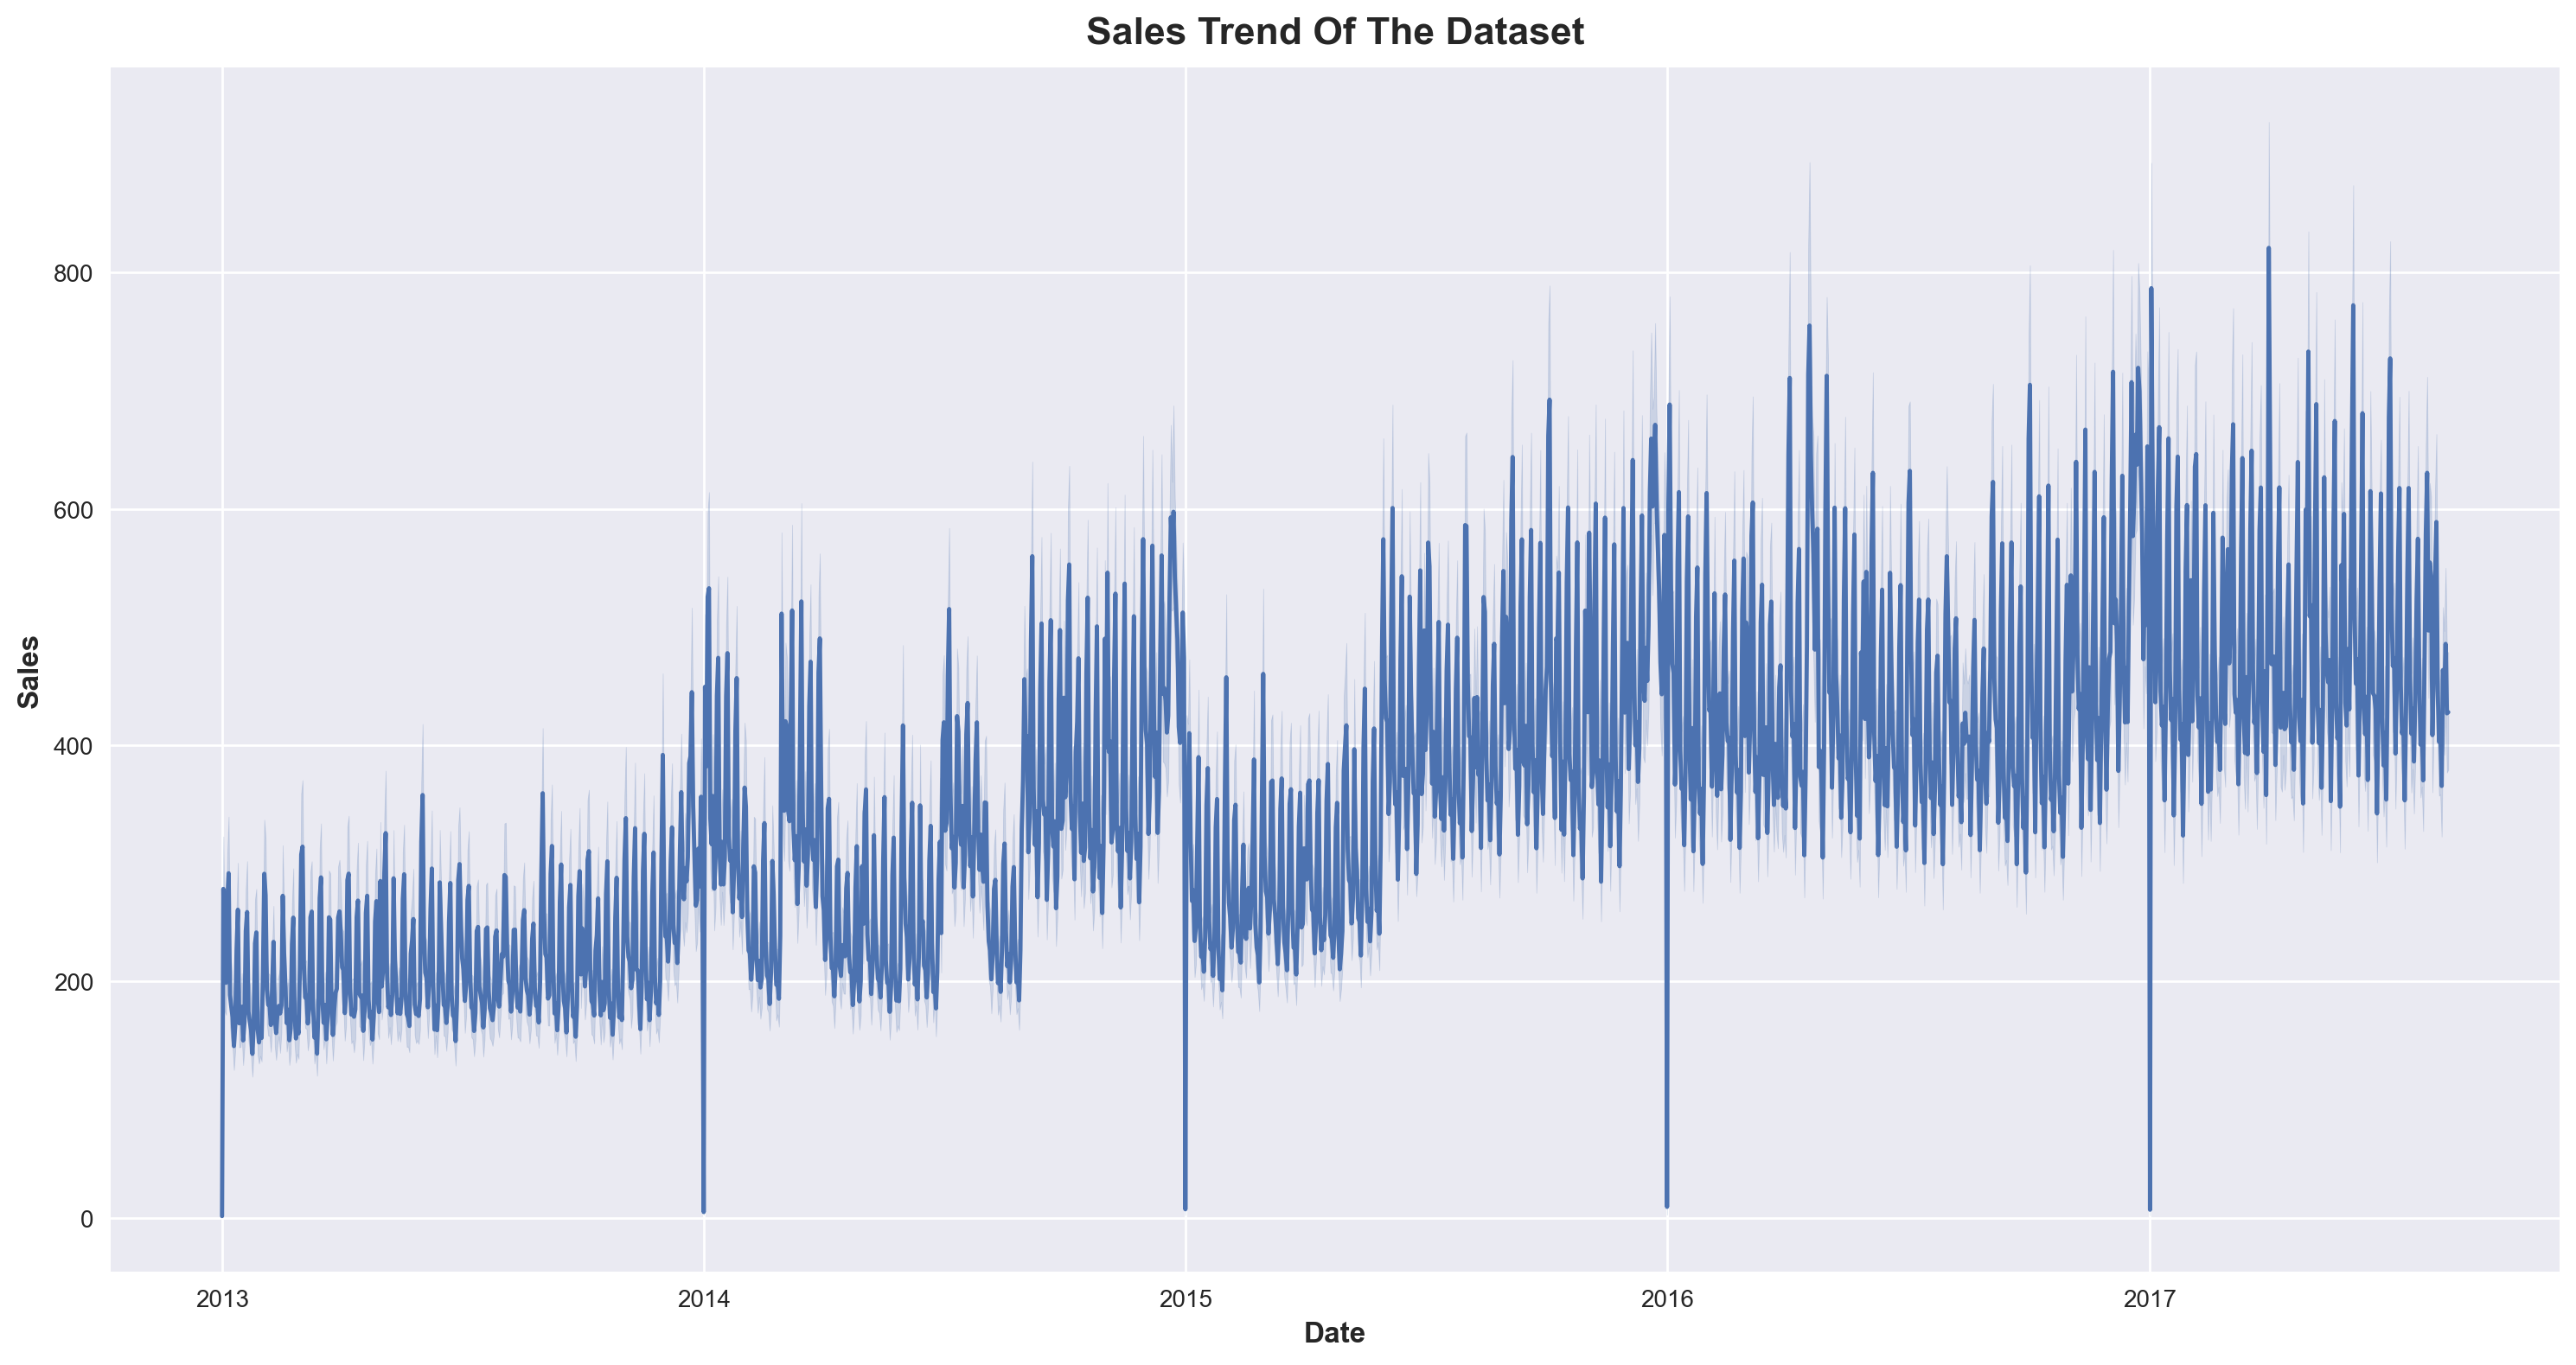

In [58]:
# Visualize the sales trend of the dataset

plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='sales', data=train_data)
plt.title('Sales Trend Of The Dataset')
plt.xlabel('Date')
plt.ylabel('Sales')


plt.show()

The sales trend above shows that there is an upward trend in the sales recorded by the retail store over the years. It also shows that there are more sales at the end of each year compared to the beginning. At the very start of each year, there are zero sales which most likely is as a result of a usual holiday break for all the retail store staff on the first day of each year.

In [59]:
# Generate summary statistics for numerical columns in train_data DataFrame

train_data.describe()

,store_nbr,sales,onpromotion,transactions,oil_price,year,month,dayofmonth,dayofweek
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,2.750000e+01,3.590209e+02,2.617480e+00,1.558656e+03,6.778930e+01,2.014842e+03,6.222870e+00,1.565694e+01,3.008168e+00
std,1.558579e+01,1.107286e+03,1.225494e+01,1.036468e+03,2.570258e+01,1.345607e+00,3.374251e+00,8.801398e+00,2.001442e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00,9.310000e+02,4.628000e+01,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00,1.332000e+03,5.319000e+01,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00
75%,4.100000e+01,1.960110e+02,0.000000e+00,1.980000e+03,9.580000e+01,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00


<Axes: >

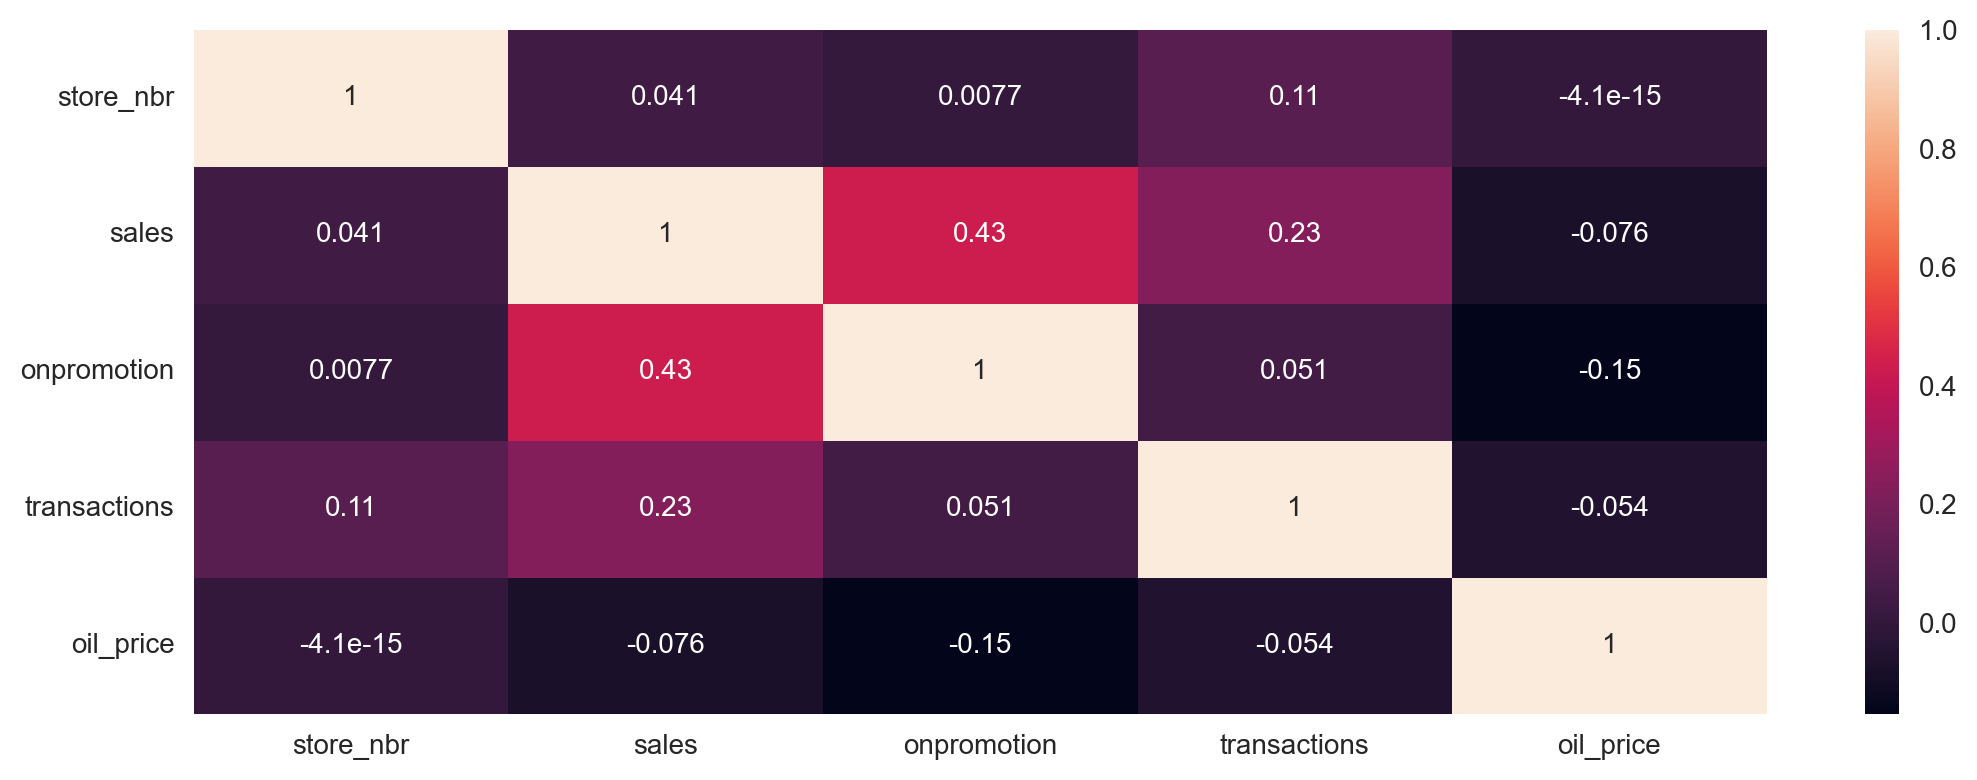

In [ ]:
# Create a DataFrame of train_data with numerical columns only
train_data_num = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_data_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

The correlation matrix above summarizes and visualizes the strength, direction of linear relationships, and patterns between the data variables.

# Hypothesis Testing

Null Hypothesis: There is no significant difference in sales before and after promotion.

Alternate Hypothesis: There is a significant difference in sales before and after promotion.

In [61]:
# Select the sales data for product family before the promotion
sales_before_promotion = train_data.loc[(train_data['family'] == 'YOUR_PRODUCT_FAMILY') & (train_data['onpromotion'] == 0), 'sales']

# Select the sales data for product family after the promotion
sales_after_promotion = train_data.loc[(train_data['family'] == 'YOUR_PRODUCT_FAMILY') & (train_data['onpromotion'] == 1), 'sales']

# Perform the paired samples t-test
t_statistic, p_value = stats.ttest_rel(sales_before_promotion, sales_after_promotion)

if p_value < 0.05:
    print('Reject null hypothesis: There is a significant difference in sales before and after promotion')
else:
    print('Fail to reject null hypothesis: There is no significant difference in sales before and after promotion')

Fail to reject null hypothesis: There is no significant difference in sales before and after promotion


The null hypothesis is accepted as there is no significant difference in sales before and after promotion.

# Test for stationarity

##### The codes below were commented out because there is insufficient memory capacity to run it

In [54]:
# Test for stationarity using the ADF test
# adf_result = adfuller(train_merged['sales'])

# Print the test results
# print(f'ADF Statistic: {adf_result[0]}')
# print(f'p-value: {adf_result[1]}')
# print(f'Critical Values: {adf_result[4]}')

# Perform hypothesis testing
# alpha = 0.05  # Significance level

# if p_value <= alpha:
#     print("Reject the null hypothesis. Series is stationary.")
# else:
#    print("Fail to reject the null hypothesis. Series is not stationary.")

# Answering Analytical Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores making more sales than others? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

8. What is the total sales made each year by the corporation?

### Question 1

##### Is the train dataset complete (has all the required dates)?

In [62]:
# Check the range of the date column
dates_range = pd.date_range(start=train_data.index.min(), end=train_data.index.max())

# Check for missing dates in the dataset
missing_dates = set(dates_range.date) - set(train_data.index.unique())

# Create a new dataframe with the dates_missing data
missing_dates_df = pd.DataFrame(missing_dates)
missing_dates_df.head()

,0
0,2014-09-10
1,2015-03-07
2,2016-01-04
3,2014-06-20
4,2017-05-29


In [64]:
# Check if April 16, 2016 (the date of the earthquake), is present in missing_dates_df
date_to_check = pd.to_datetime('2016-04-16')
is_april_16_present = date_to_check in missing_dates_df.values

print(" Is April 16, 2016, (the date of the earthquake) among the missing dates?:", is_april_16_present)

 Is April 16, 2016, (the date of the earthquake) among the missing dates?: False


Although the dates include April 16, 2016, (the date of the earthquake), there are other missing dates. This means that the dataset is not complete.

### Question 2

##### Which dates have the lowest and highest sales for each year?

The dates where the sales made is 0 are most likely the dates that the outlets of the retail store were not open. Such days are not considered as dates with the lowest sales because the store was not even open for sales at all.

In [65]:
# Group the data by year
grouped_data = train_data.groupby('year')

# Find the dates with the highest and lowest sales for each year, excluding the dates with zero sales
years = []
max_dates = []
max_sales = []
min_dates = []
min_sales = []

for year, group in grouped_data:
    nonzero_sales_group = group[group['sales'] > 0]
    if not nonzero_sales_group.empty:
        max_sale_date = nonzero_sales_group['sales'].idxmax()
        min_sale_date = nonzero_sales_group['sales'].idxmin()
        max_sale_value = nonzero_sales_group['sales'].max()
        min_sale_value = nonzero_sales_group['sales'].min()

        years.append(year)
        max_dates.append(max_sale_date)
        max_sales.append(max_sale_value)
        min_dates.append(min_sale_date)
        min_sales.append(min_sale_value)

# Create the result DataFrame
result_data = {
    'Year': years,
    'Highest_Sales_Date': max_dates,
    'Highest_Sales': max_sales,
    'Lowest_Sales_Date': min_dates,
    'Lowest_Sales': min_sales
}
result_df = pd.DataFrame(result_data)
result_df

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,2013-11-12,46271.000,2013-08-06,0.122
1,2014,2014-12-08,45361.000,2014-12-05,0.188
2,2015,2015-12-14,40351.460,2015-09-15,0.196
3,2016,2016-05-02,124717.000,2016-06-23,0.396
4,2017,2017-04-02,38422.625,2017-02-09,0.426


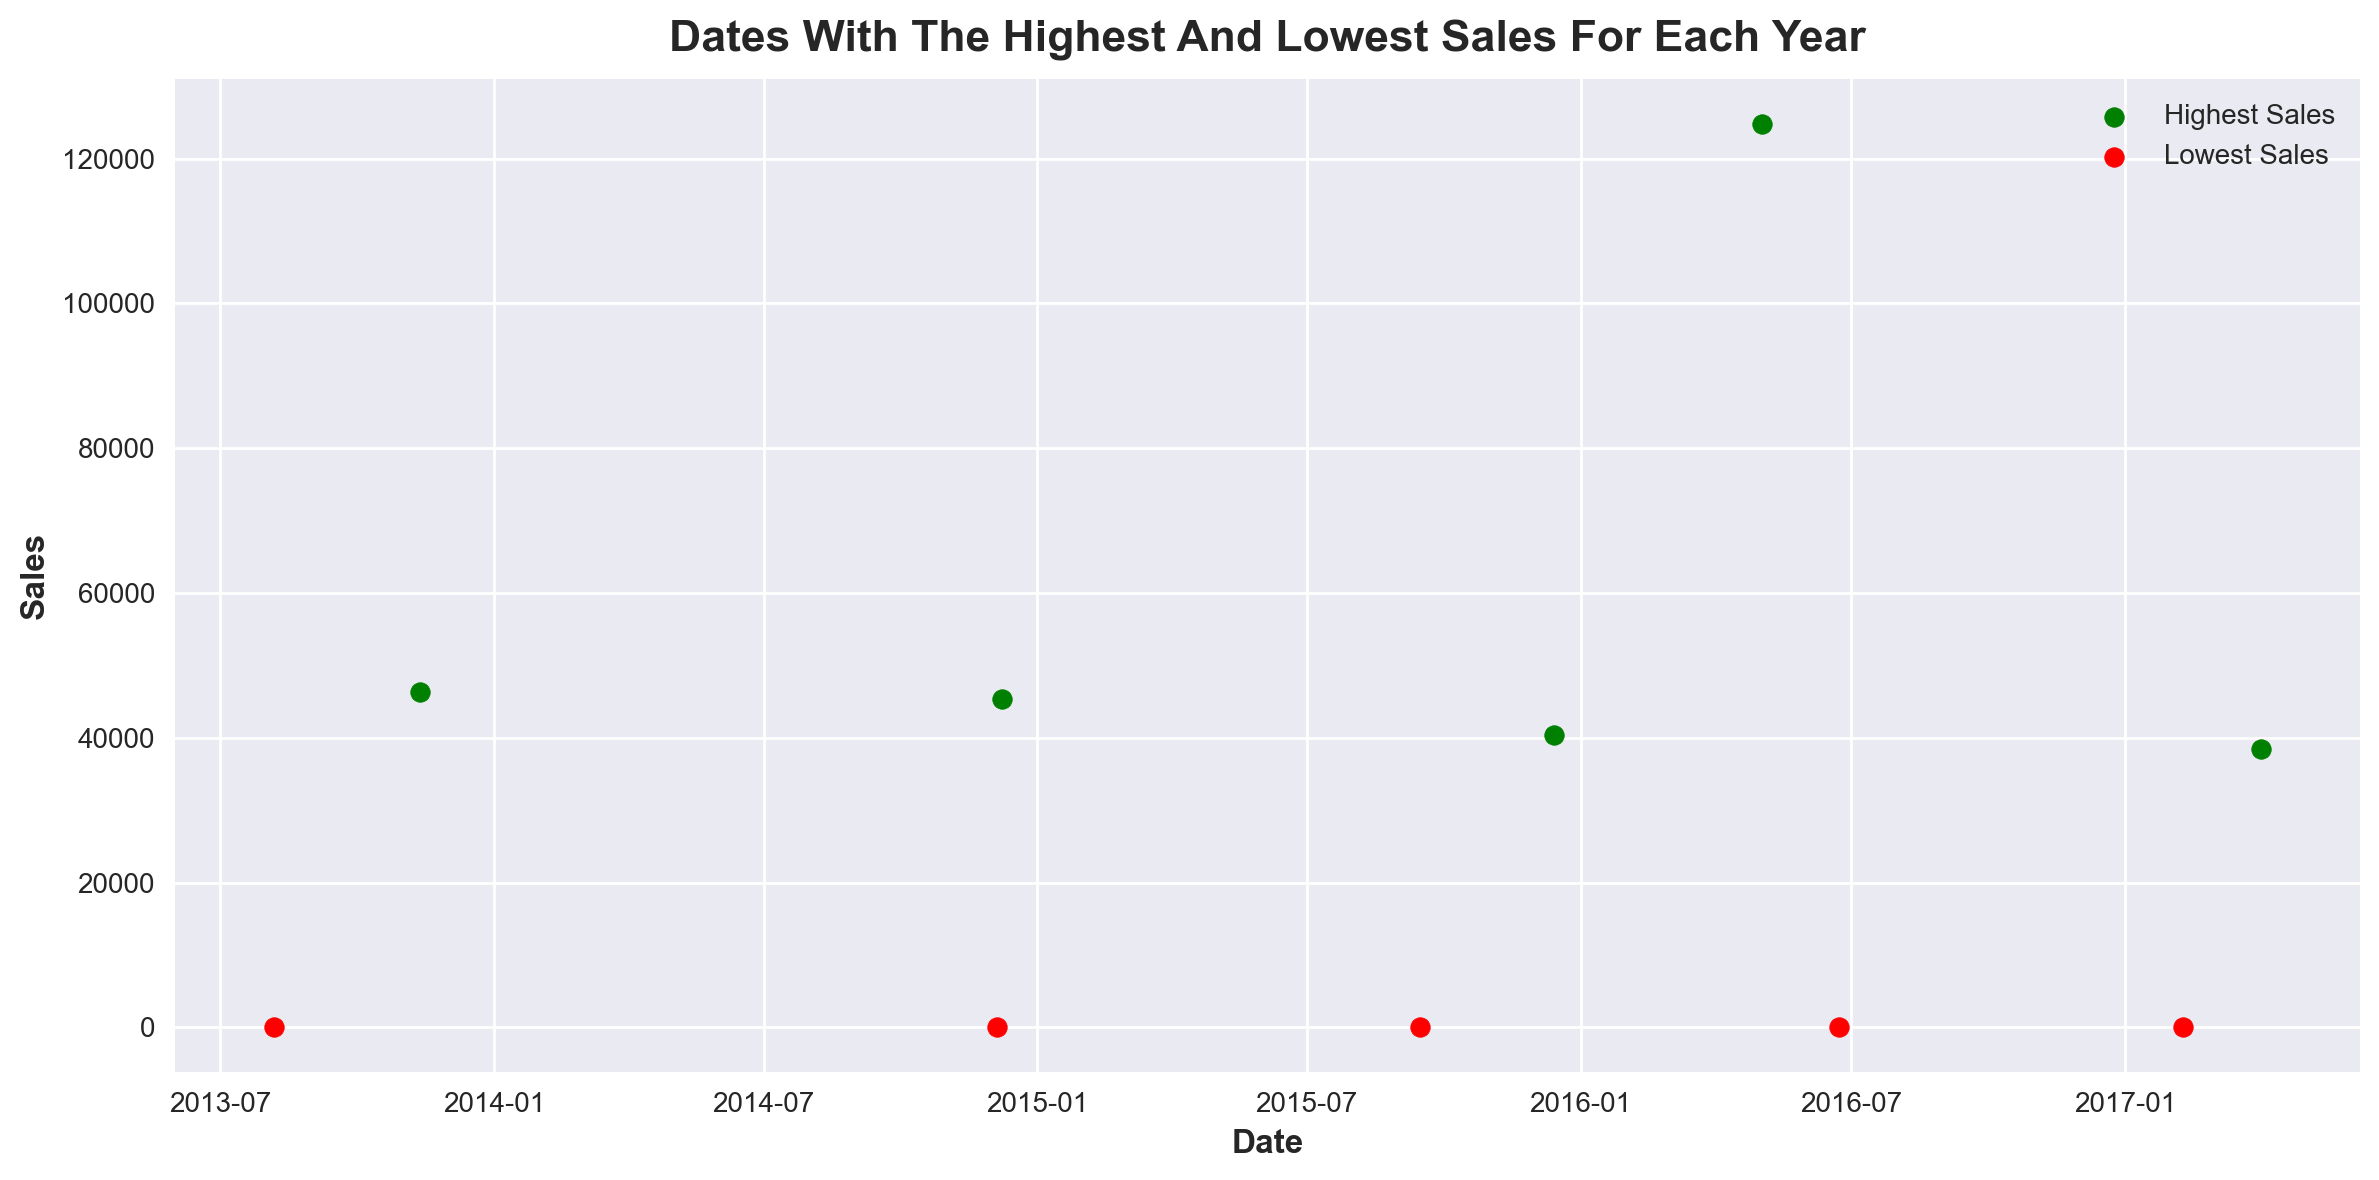

In [66]:
# Visualize the dates that have the lowest and highest sales for each year on a chart

plt.figure(figsize=(12, 6))
plt.scatter(result_df['Highest_Sales_Date'], result_df['Highest_Sales'], color='green', label='Highest Sales', marker='o')
plt.scatter(result_df['Lowest_Sales_Date'], result_df['Lowest_Sales'], color='red', label='Lowest Sales', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.title('Dates With The Highest And Lowest Sales For Each Year')

# Display the plot
plt.show()

### Question 3

Did the earthquake impact sales?

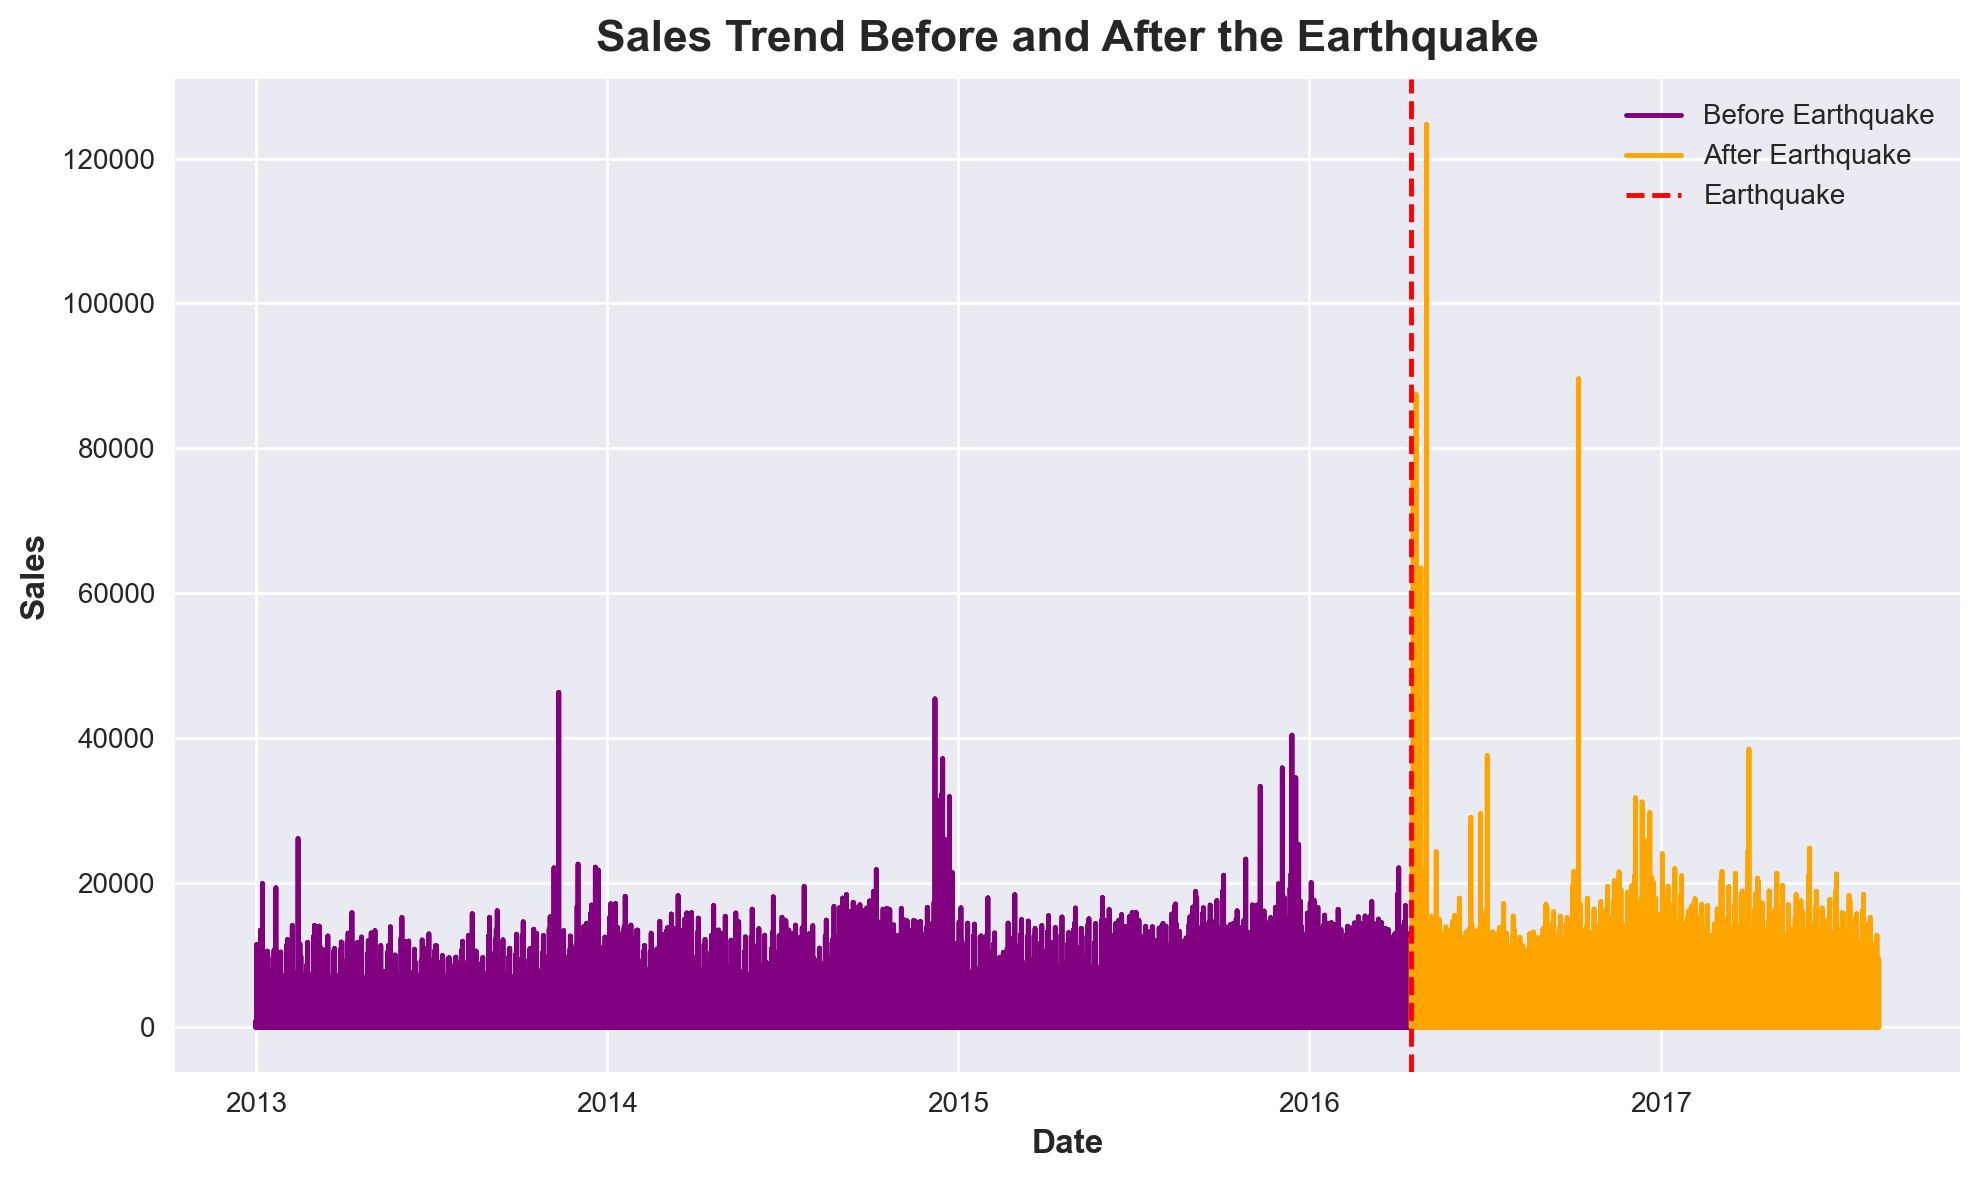

In [67]:
# Convert 'date' from index to a regular column
train_data.reset_index(inplace=True)

# Filter the data for the period before and after the earthquake
before_earthquake_df = train_data[train_data['date'] < '2016-04-16']
after_earthquake_df = train_data[train_data['date'] >= '2016-04-16']

# Visualize the impact of the earthquake on sales
plt.figure(figsize=(10, 6))
plt.plot(before_earthquake_df['date'], before_earthquake_df['sales'], color='purple', label='Before Earthquake')
plt.plot(after_earthquake_df['date'], after_earthquake_df['sales'], color='orange', label='After Earthquake')
plt.axvline(x=pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Earthquake')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Before and After the Earthquake')
plt.legend()
plt.show()

# Revert 'date' back to an index
train_data.set_index('date', inplace=True)

The date of the earthquake is marked with the red dash line. As observed on the chat, there was a huge increase in sales immediately after the earthquake. This could be because people needed to stock up food stuffs to be able to stay indoors after the earthquake. Another reason could be that hospitals and emergency corporations needed to buy large amounts of materials to cater for the earthquake victims. It is clear, therefore, that the earthquake impacted the sales of the retail store.

### Question 4

Are certain groups of stores making more sales than others? (Cluster, city, state, type)

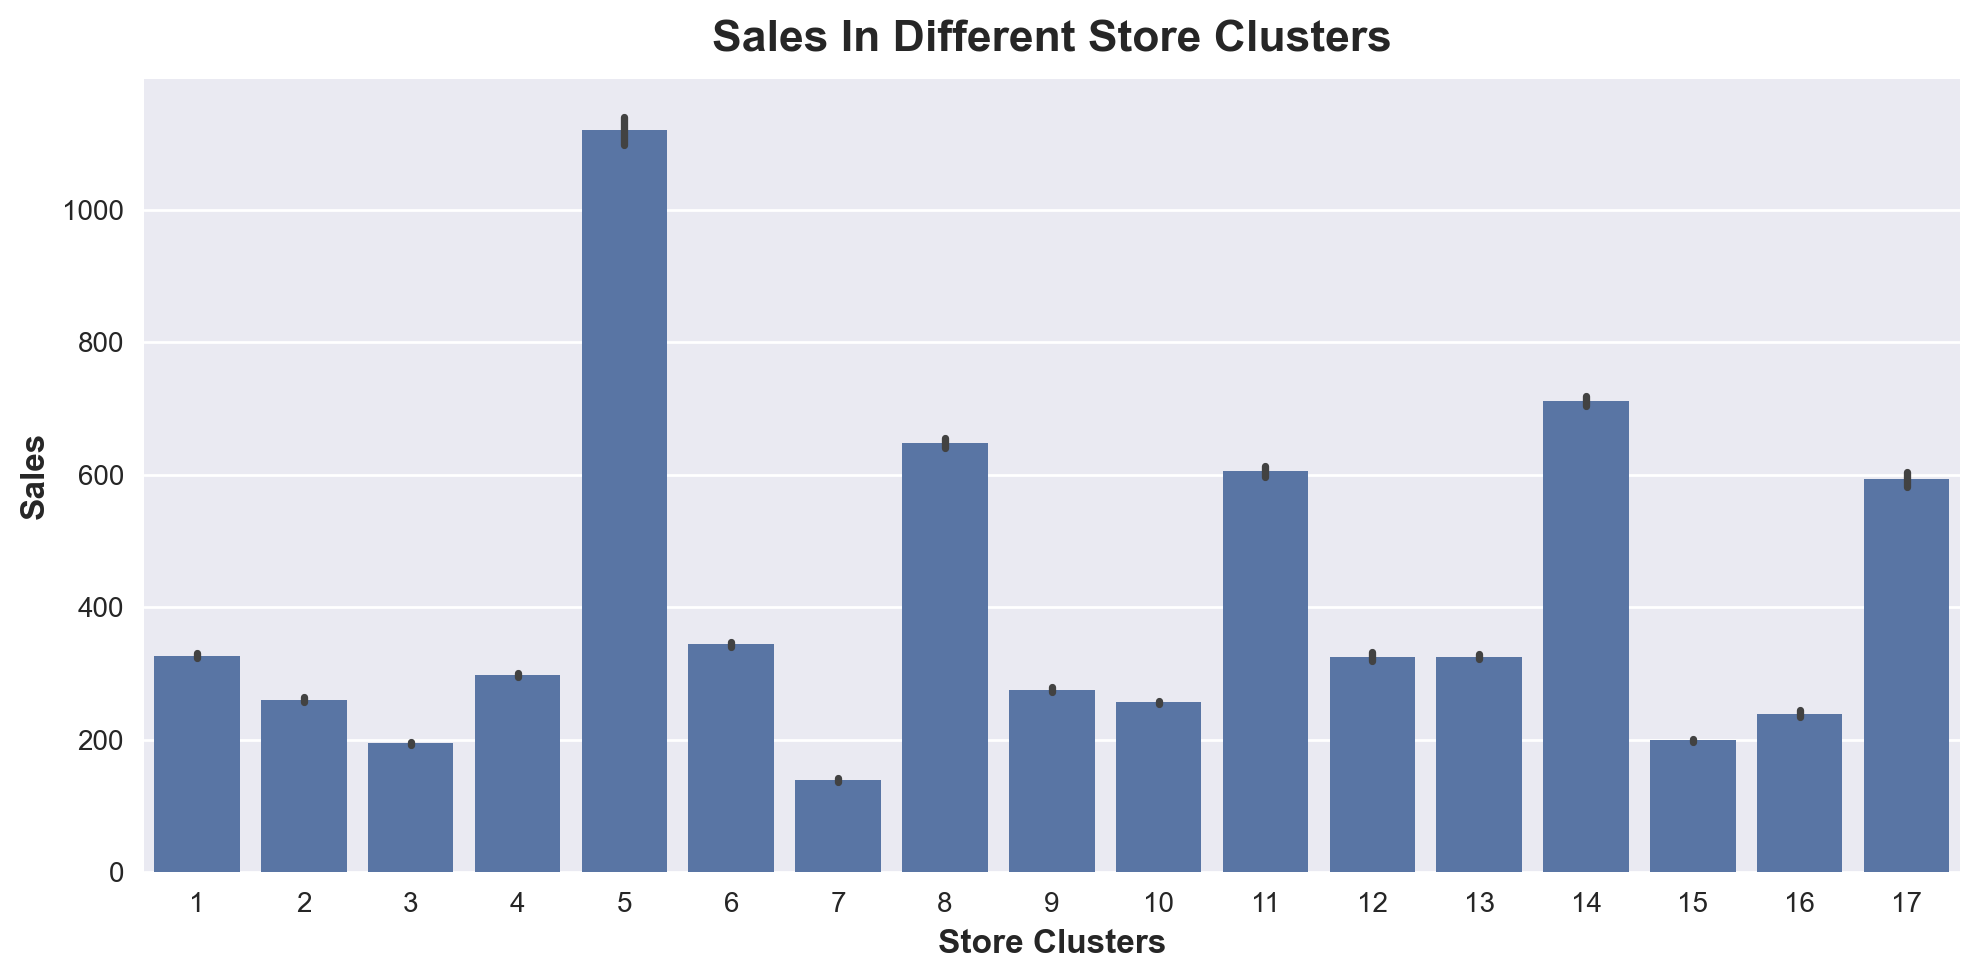

In [68]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=train_data)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in cluster 5 are making more sales than the stores in other clusters, followed by stores in cluster 14, while stores in cluster 7 made the least sales. It further shows that the stores in different clusters are making different volume of sales, with some stores making more sales than others.

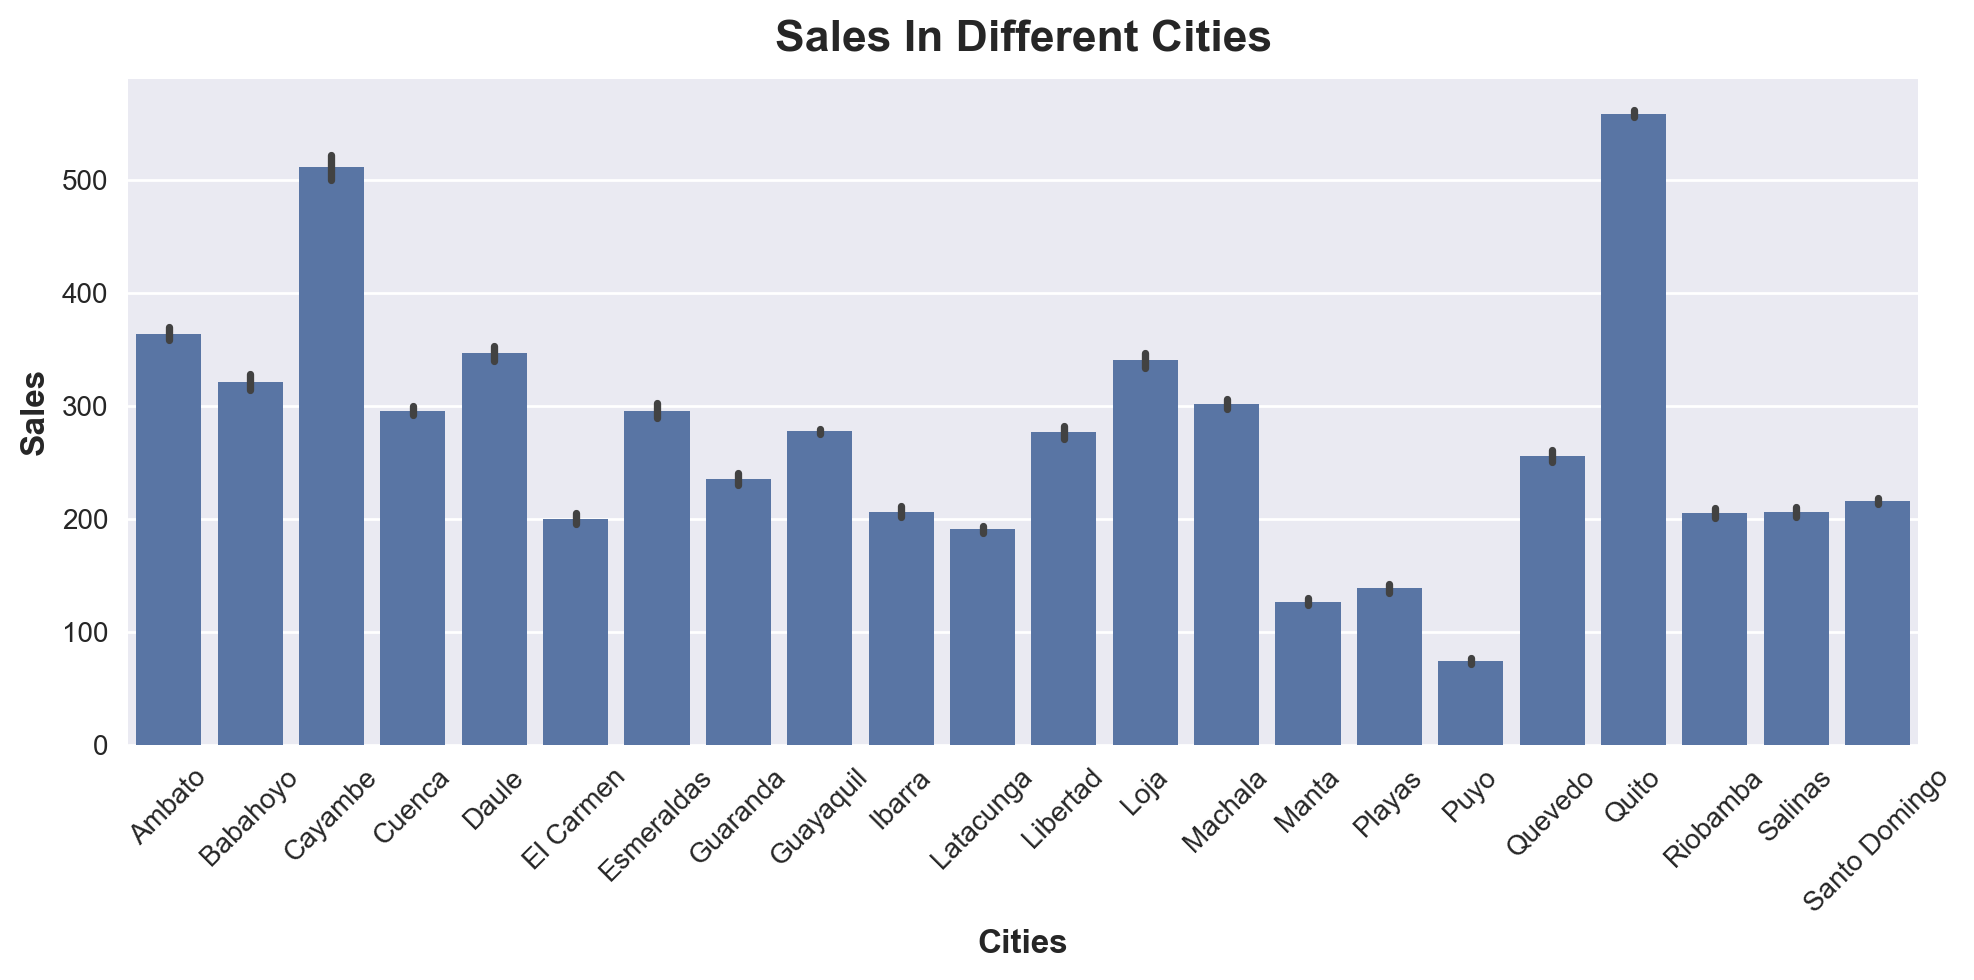

In [69]:
# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=train_data)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

The plot above shows that stores in Quito are making more sales than stores in other cities, followed by stores in Cayambe, while stores in Puyo made the least sales. It further shows that the stores in different cities are making different volume of sales, with some stores making more sales than others.

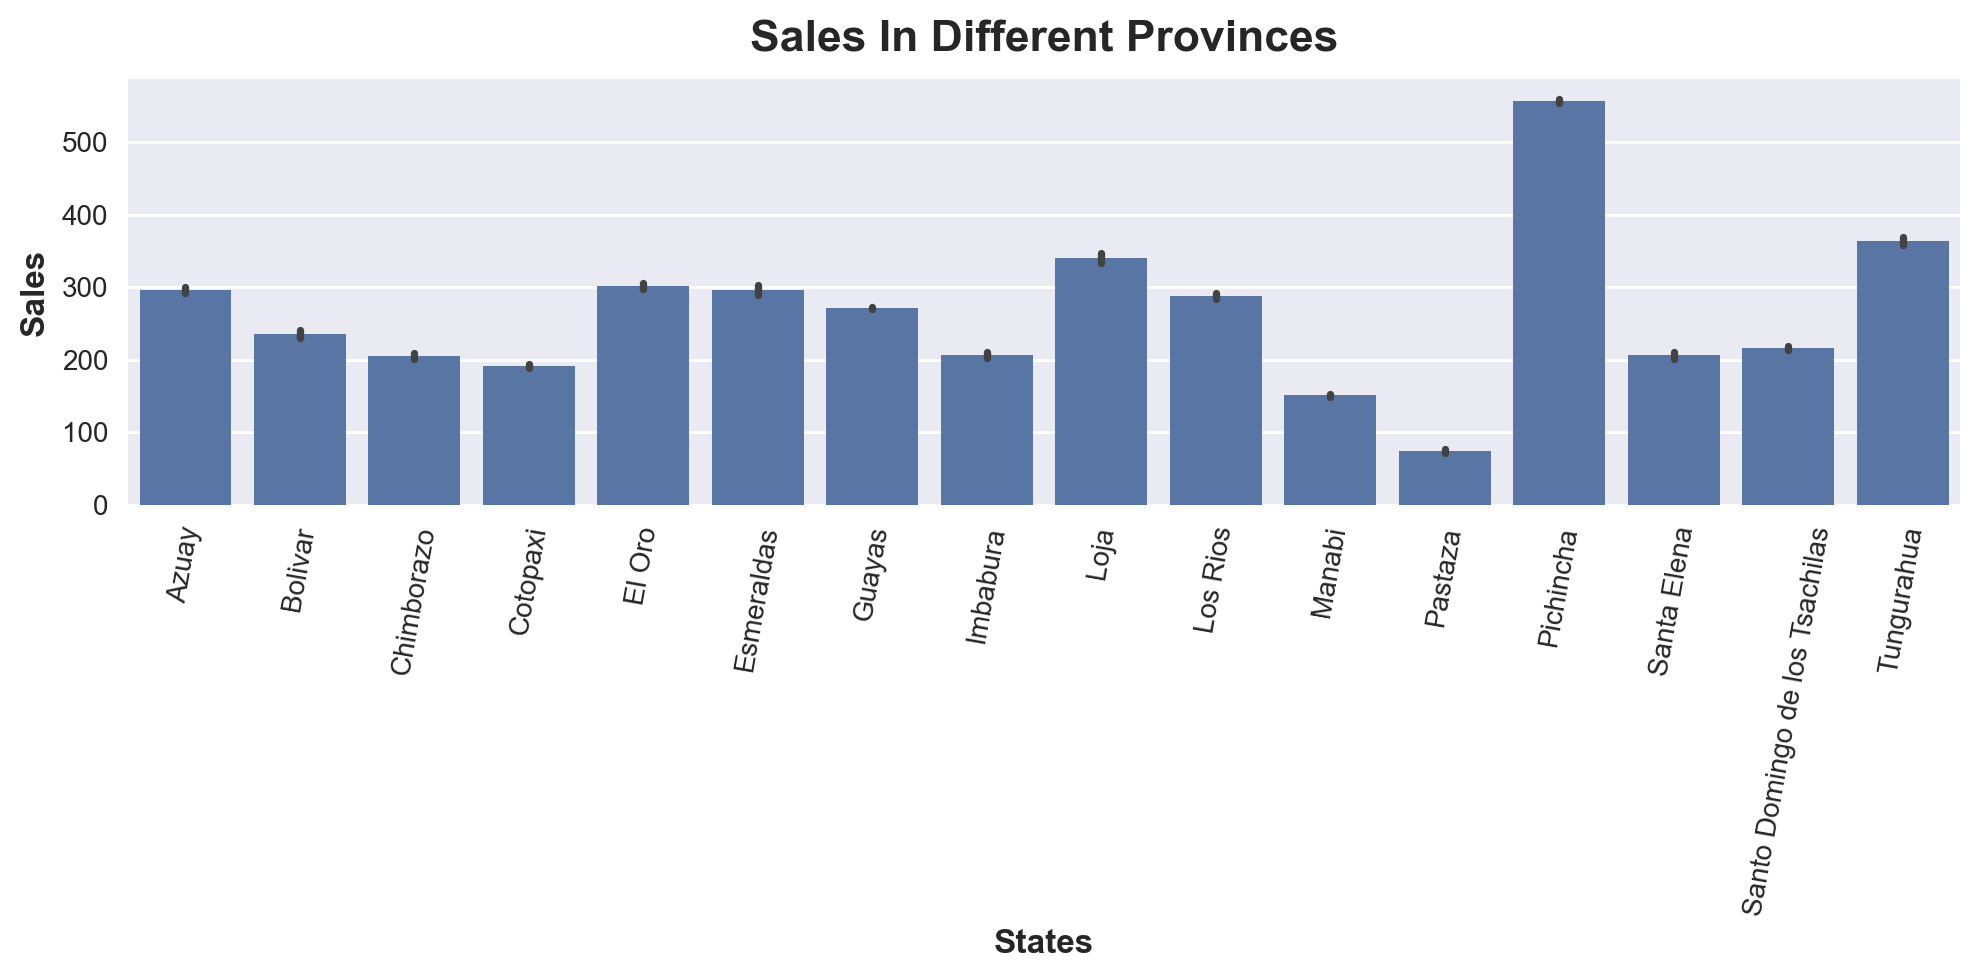

In [71]:
# Compare the sales in different provinces

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=train_data)
plt.title('Sales In Different Provinces')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

The plot above shows that stores in Pichincha are making more sales than stores in other states, followed by stores in Tungurahua, while stores in Pastaza made the least sales. It further shows that the stores in different states are making different volume of sales, with some stores making more sales than others.

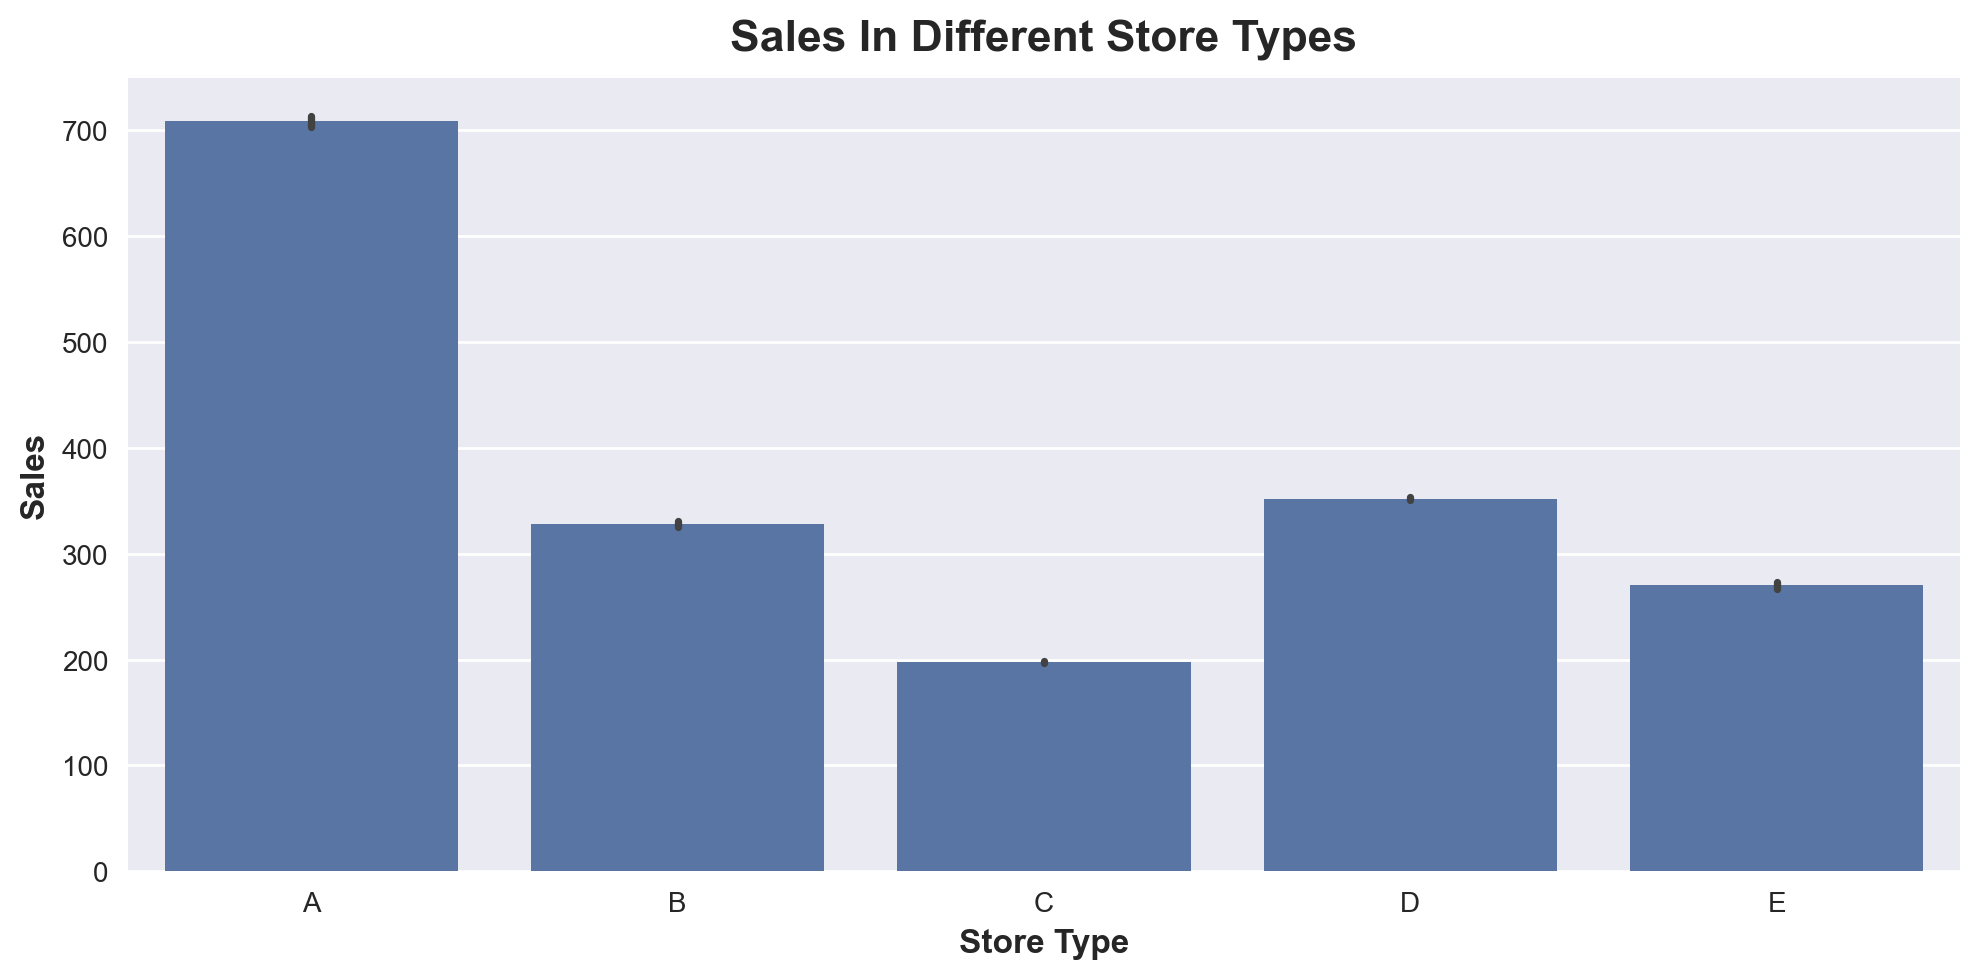

In [72]:
# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=train_data, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in Store type A are making more sales than stores in other store types, followed by stores in Store type D, while stores in Store type C made the least sales. It further shows that the stores in different store types are making different volume of sales, with some stores making more sales than others.

In summary, there are groups of stores across the clusters, cities, states, and store types that are making more sales than others.

### Question 5

Are sales affected by promotions, oil prices and holidays?

##### Effect of promotions on sales

Text(0, 0.5, 'Sales')

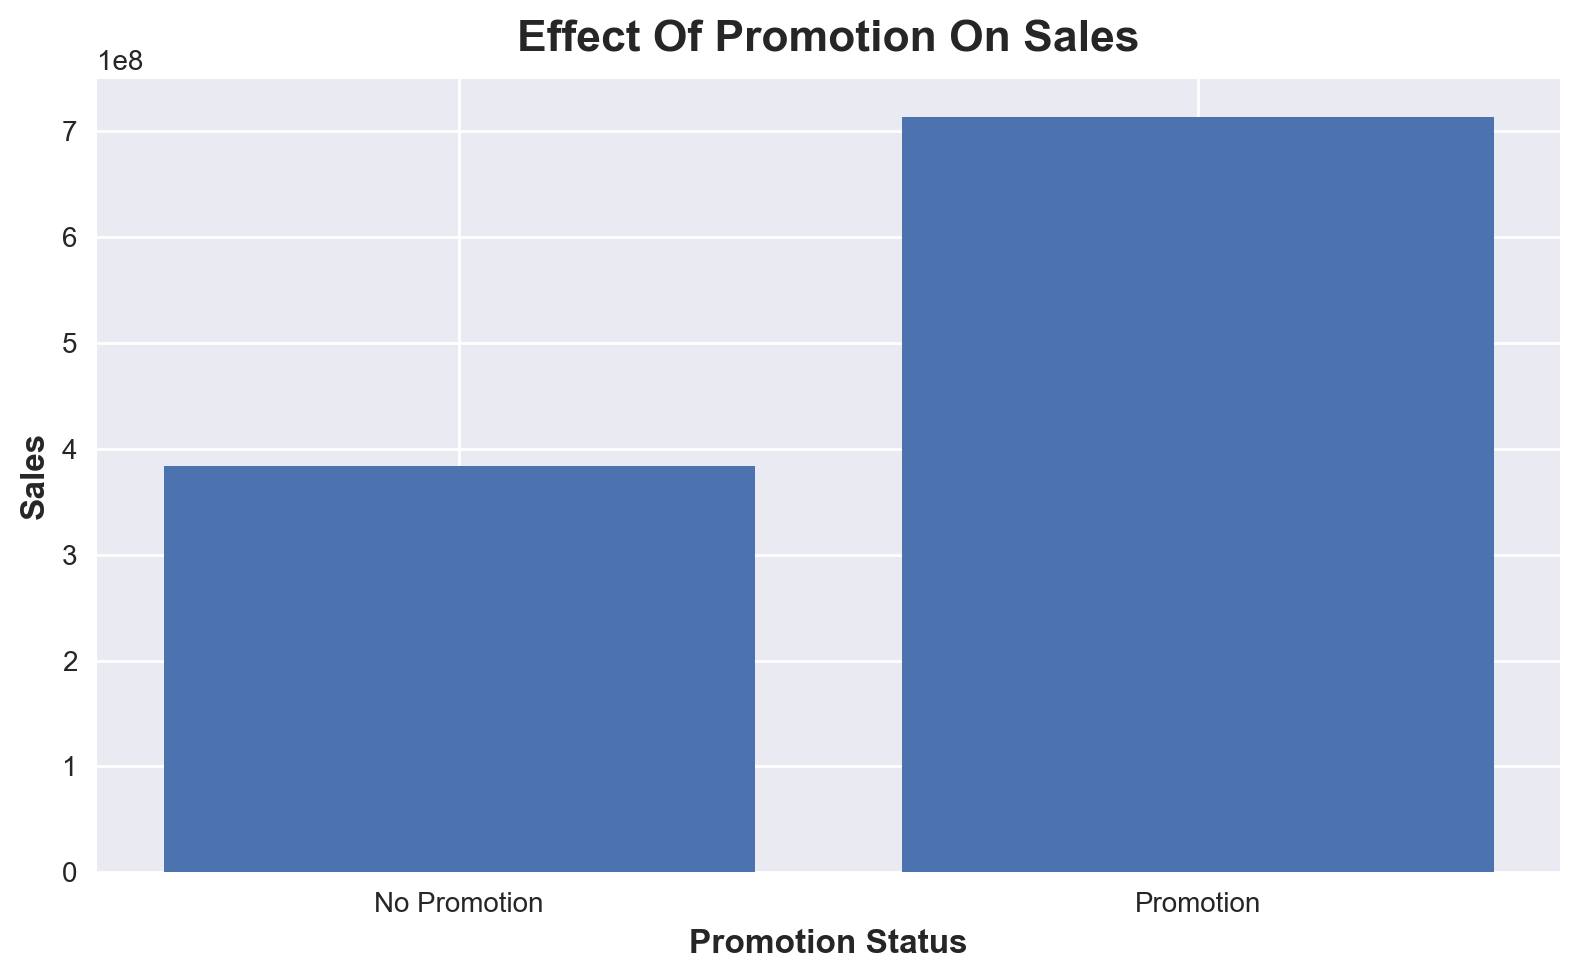

In [73]:
# Identify families with at least one item on promotion and families with no item on promotion
train_data['promotion_status'] = train_data['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = train_data.groupby(['promotion_status'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.promotion_status, x.sales)
plt.title('Effect Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

The plot above shows that sales was affected by promotion. Product families with items on promotion are being sold more than product families with no item on promotion.

##### Effect of oil prices on sales

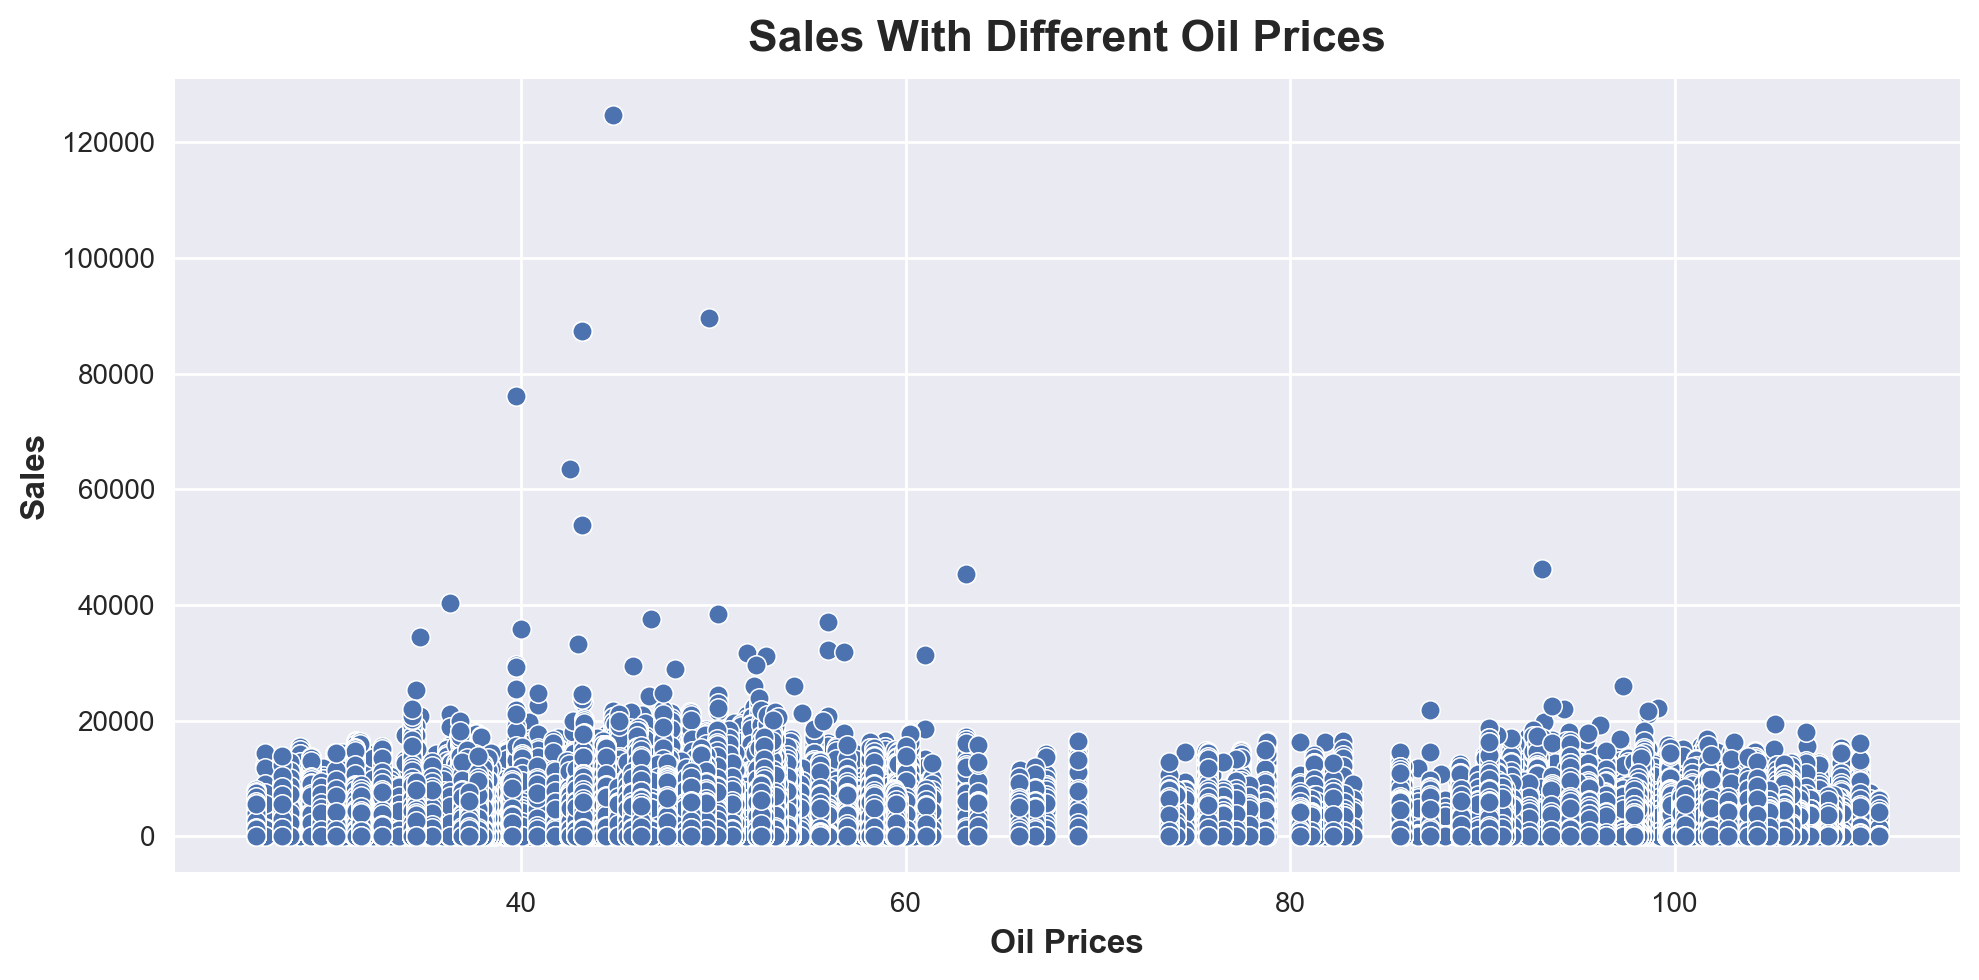

In [74]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='oil_price', y='sales', data=train_data)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

The plot above shows that sales are affected by the oil prices. As shown, there are more number of sales at lower oil prices than at higher oil prices. The outliers shown represent occasions where huge volumes of sales occurred. These huge volume trades occurred more frequently at lower oil prices than at higher oil prices.

##### Effect of holidays on sales

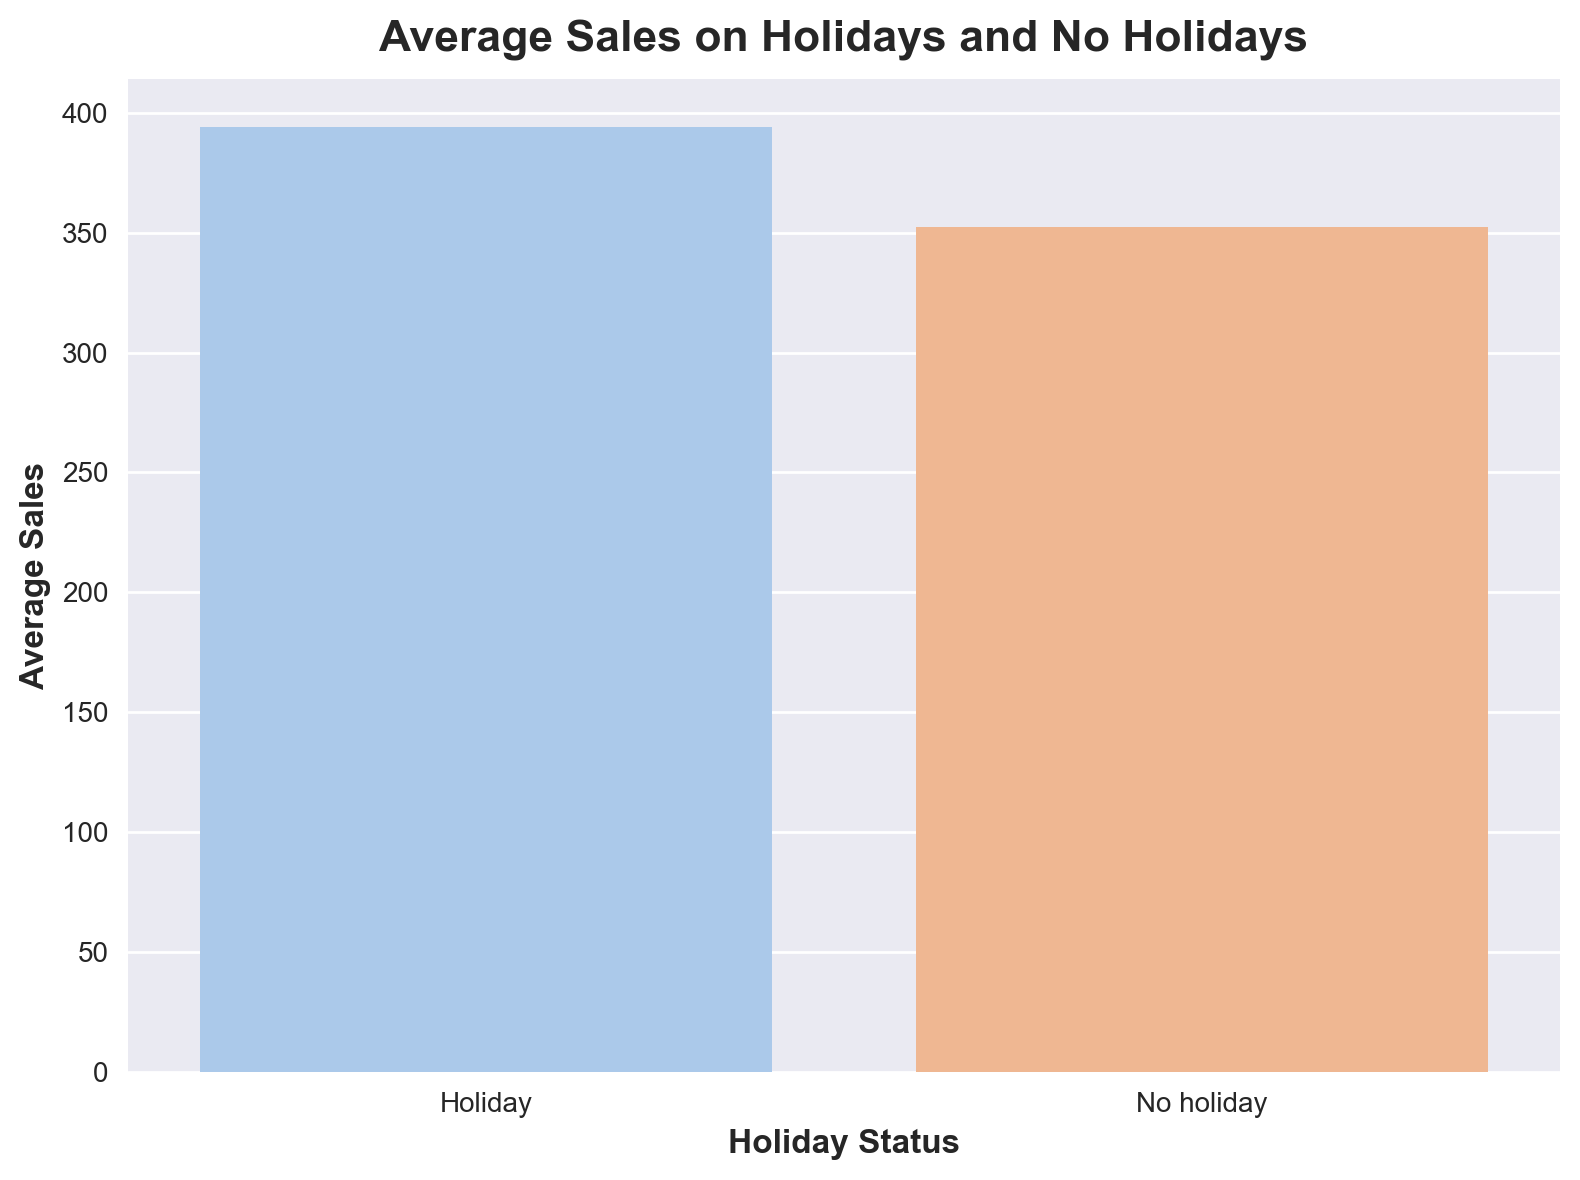

In [75]:
# Group the data by 'holiday_status' and calculate the average sales for each category
average_sales_by_holiday_status = train_data.groupby('holiday_status')['sales'].mean().reset_index()

# Plot the average sales for holidays and no holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_status', y='sales', data=average_sales_by_holiday_status, palette='pastel')
plt.xlabel('Holiday Status')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays and No Holidays')
plt.show()

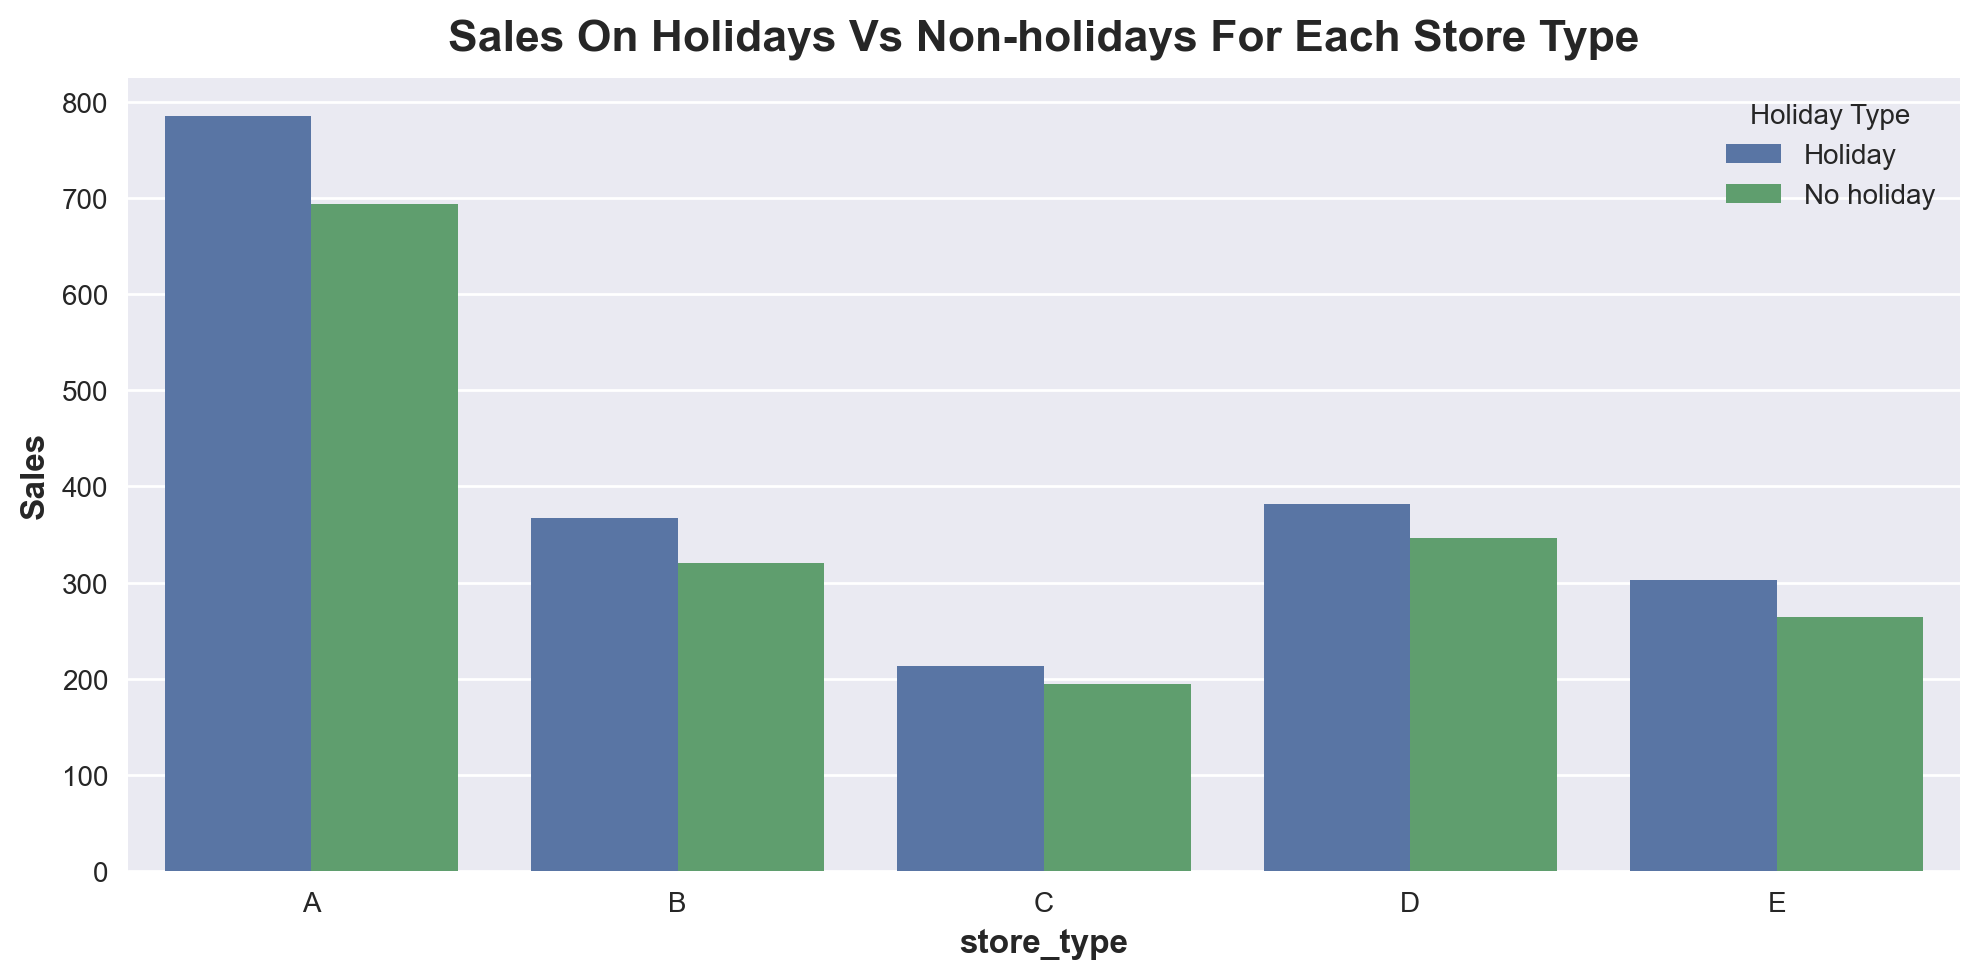

In [76]:
# Compare the sales on holidays with sales on non-holidays for the different store types

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', hue='holiday_status', y='sales', data=train_data, ci=None, order=store_types)
plt.title('Sales On Holidays Vs Non-holidays For Each Store Type')
plt.ylabel('Sales')
plt.legend(title='Holiday Type')
plt.show()

In the first plot above, there are higher sales on holidays than no holidays. This is because more people are free to go out for shopping on holidays than no holidays when they have to be at work or school.

In the second plot above, there are more sales on holidays than no holidays across all the store types. 

For these reasons, we conclude that sales were affected by holidays.

### Question 6

What analysis can we get from the date and its extractable features?

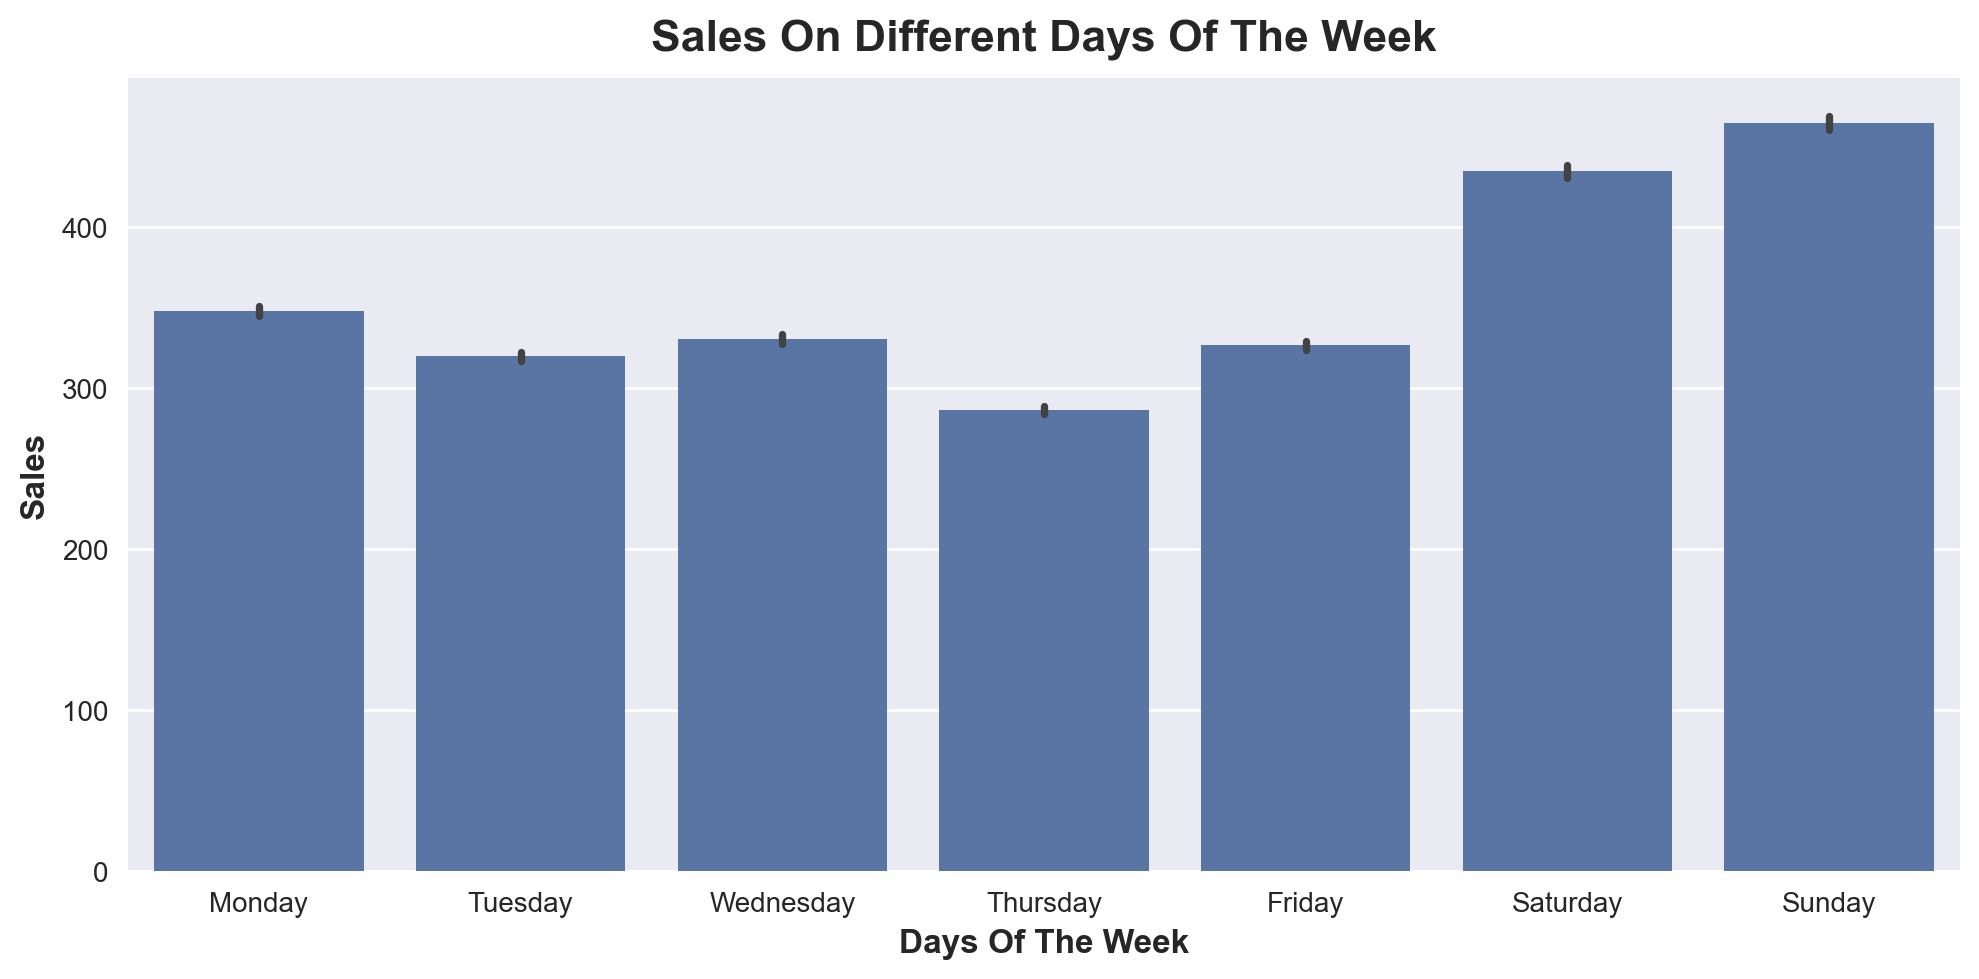

In [77]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=train_data, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

From the date and its extractable features, we can analyze the sales on the different days of the week as shown in the plot. There are more sales during the weekends with peak sales on Sundays, followed by Saturdays. This could be because generally many people do not go to work (or only work few hours) during the weekends, and thus would have more time to shop during weeekends than weekdays. The least sales were on Thursdays, a quite busy day at at the middle of the week.

### Question 7

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is less sensitive to outliers but generally larger than RMSE and MSE.

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors, making it sensitive to outliers.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors and is less sensitive to outliers in the target variable.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

### Question 8

What is the total sales made each year by the corporation?

In [78]:
# Group by year and sum the sales for each year

total_sales_per_year = train_data.groupby(['year'], as_index=False).agg({'sales':'sum'})
total_sales_per_year

,year,sales
0,2013,1.424880e+08
1,2014,2.130044e+08
2,2015,2.438321e+08
3,2016,2.991820e+08
4,2017,1.980683e+08


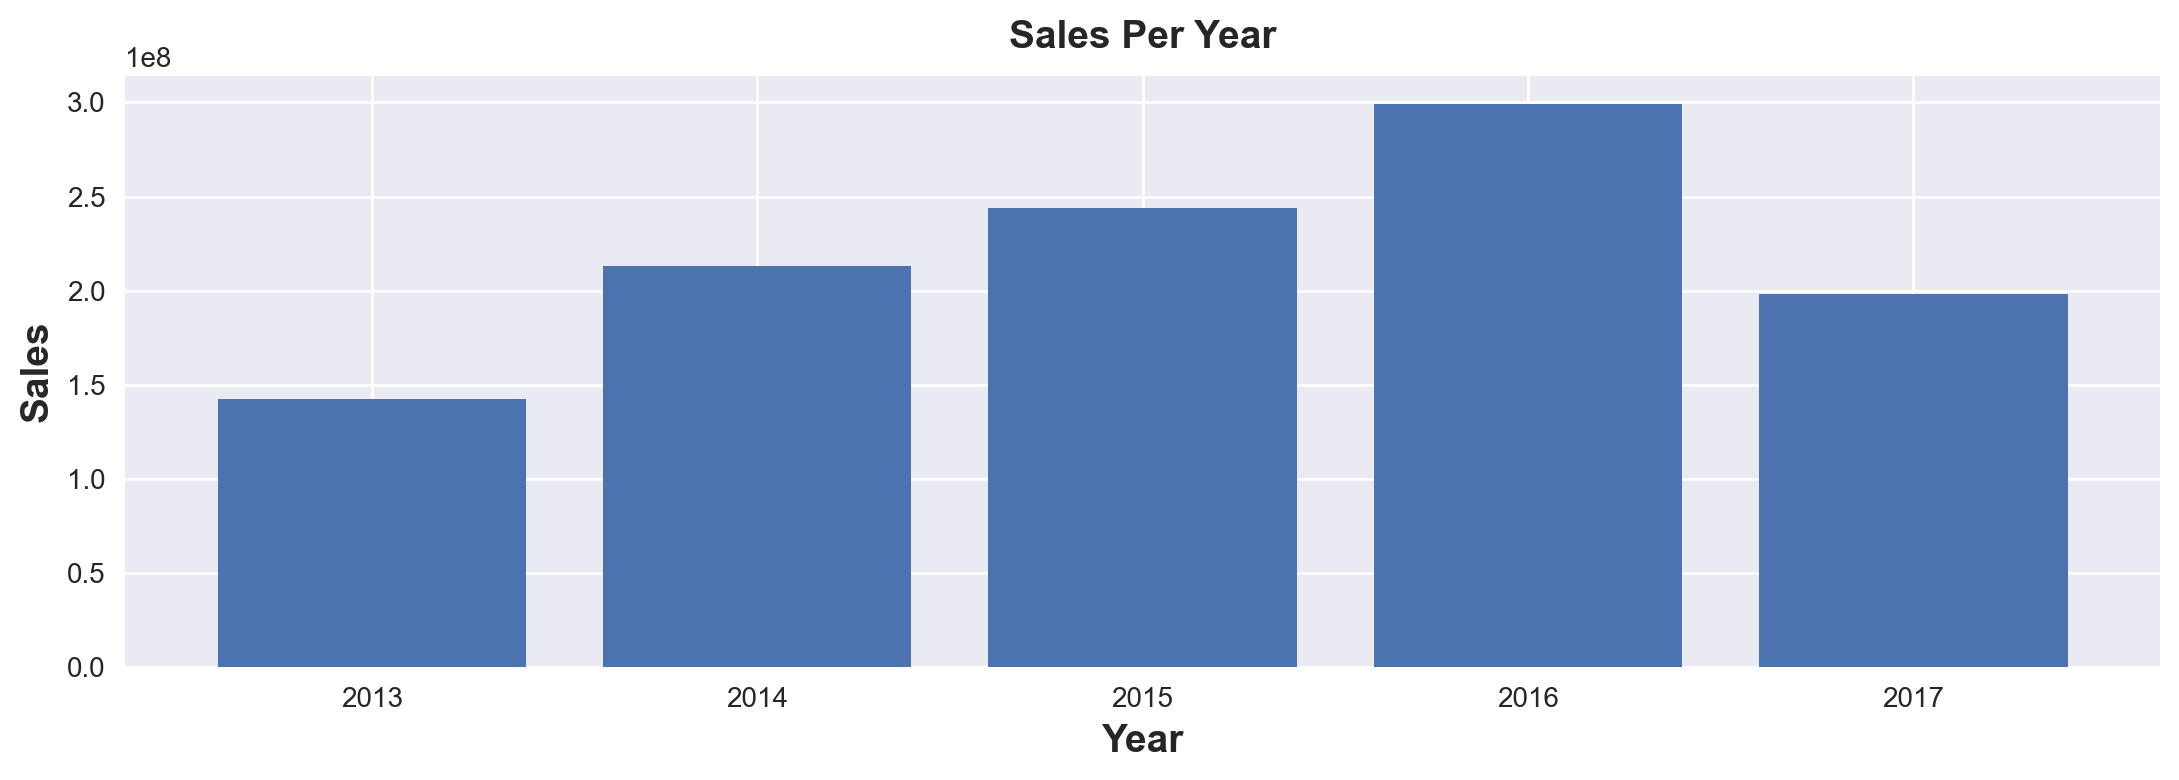

In [79]:
# Plot the total sales made each year

plt.bar(total_sales_per_year.year, total_sales_per_year.sales)
plt.title('Sales Per Year',fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

The image above displays the total sales made each year by Corporation Favorita. It reveals that Corporation Favorita made it's lowest sales in 2013 and its highest sales in 2016.

Recall that the earthquake occured on 16th April, 2016 (2016–04–16), and it led to a huge increase in sales. This increase in sales as a result of the earthquake in 2016 contributed enormously to the sales of Corporation Favorita, enabling Corporation Favorita to record it's highest sales in 2016 across the years captured in the entire data collected.

# Save Train Dataset

In [80]:
# Save the train dataset as a csv, create a new copy, then carry out feature engineering on the new copy

train_data.to_csv('cleaned_train.csv')
train_df = train_data.copy()

In [9]:
# Open de dataset

# Ruta absoluta con prefijo r para evitar errores por espacios o barras
df_train = pd.read_csv(r'C:\Users\USUARIO\OneDrive - yachaytech.edu.ec\YachayTech\Time_series\cleaned_train.csv')

print(df_train.head())  # Muestra las primeras filas para verificar


         date  store_nbr      family  sales  onpromotion  transactions  \
0  2013-01-01          1  AUTOMOTIVE    0.0            0           0.0   
1  2013-01-01          1   BABY CARE    0.0            0           0.0   
2  2013-01-01          1      BEAUTY    0.0            0           0.0   
3  2013-01-01          1   BEVERAGES    0.0            0           0.0   
4  2013-01-01          1       BOOKS    0.0            0           0.0   

  holiday_type    locale locale_name         description  ...      state  \
0      Holiday  National     Ecuador  Primer dia del ano  ...  Pichincha   
1      Holiday  National     Ecuador  Primer dia del ano  ...  Pichincha   
2      Holiday  National     Ecuador  Primer dia del ano  ...  Pichincha   
3      Holiday  National     Ecuador  Primer dia del ano  ...  Pichincha   
4      Holiday  National     Ecuador  Primer dia del ano  ...  Pichincha   

   store_type cluster holiday_status  year  month dayofmonth  dayofweek  \
0           D      13  

# Feature Engineering

Feature engineering processes include feature selection, data splitting, feature encoding, feature scaling etc. These processes are required to prepare the dataset for modelling.

### Feature Selection

In [81]:
# Display random sample of 10 rows to see the contents of the columns

train_df.sample(10, random_state = 42)

,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,...,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname,promotion_status
date,,,,,,,,,,,,,,,,,,,,,
2014-01-07,23,DAIRY,471.000,0,1135.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Tungurahua,D,9,No holiday,2014,1,7,1,Tuesday,No Promotion
2014-12-05,1,BEAUTY,1.000,0,2028.0,Additional,Local,Quito,Fundacion de Quito-1,False,...,Pichincha,D,13,Holiday,2014,12,5,4,Friday,No Promotion
2014-07-06,45,HOME APPLIANCES,0.000,0,4626.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Pichincha,A,11,No holiday,2014,7,6,6,Sunday,No Promotion
2014-05-02,20,LAWN AND GARDEN,0.000,0,0.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Pichincha,B,6,No holiday,2014,5,2,4,Friday,No Promotion
2014-02-25,25,HOME AND KITCHEN II,0.000,0,705.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Santa Elena,D,1,No holiday,2014,2,25,1,Tuesday,No Promotion
2014-01-26,49,PRODUCE,7866.909,0,2744.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Pichincha,A,11,No holiday,2014,1,26,6,Sunday,No Promotion
2014-11-23,49,GROCERY II,107.000,0,3096.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Pichincha,A,11,No holiday,2014,11,23,6,Sunday,No Promotion
2013-08-24,20,PRODUCE,0.000,0,0.0,Holiday,Local,Ambato,Fundacion de Ambato,False,...,Pichincha,B,6,Holiday,2013,8,24,5,Saturday,No Promotion
2015-08-02,4,CELEBRATION,11.000,0,1716.0,No holiday,No holiday,No holiday,No holiday,No holiday,...,Pichincha,D,9,No holiday,2015,8,2,6,Sunday,No Promotion


In [82]:
# Display all the columns of the dataset

train_df.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'oil_price', 'city', 'state', 'store_type', 'cluster', 'holiday_status',
       'year', 'month', 'dayofmonth', 'dayofweek', 'dayname',
       'promotion_status'],
      dtype='object')

In [7]:
# Set the 'date' column as index

df_train = df_train.set_index('date')
df.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,state,store_type,cluster,holiday_status,year,month,dayofmonth,dayofweek,dayname,promotion_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday,No Promotion
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday,No Promotion
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday,No Promotion
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday,No Promotion
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,Pichincha,D,13,Holiday,2013,1,1,1,Tuesday,No Promotion


In [8]:
df_train.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'oil_price', 'city', 'state', 'store_type', 'cluster', 'holiday_status',
       'year', 'month', 'dayofmonth', 'dayofweek', 'dayname',
       'promotion_status'],
      dtype='object')

In [83]:
# Drop some columns and display the dataset
columns_to_drop = ['promotion_status', 'transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'oil_price', 'city',
                   'state', 'store_type', 'cluster', 'holiday_status', 'month', 'dayofmonth', 'dayofweek', 'dayname']
train_df = train_df.drop(columns_to_drop, axis=1)

train_df.head()

,store_nbr,family,sales,onpromotion,year
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013
2013-01-01,1,BABY CARE,0.0,0,2013
2013-01-01,1,BEAUTY,0.0,0,2013
2013-01-01,1,BEVERAGES,0.0,0,2013
2013-01-01,1,BOOKS,0.0,0,2013


### Data Splitting

The dataset will be splitted to training and validation sets using the time-based split. This will be done based on the years.

In [84]:
# List the years in the dataset

train_df['year'].unique()

array([2013, 2014, 2015, 2016, 2017])

In [85]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = train_df.loc[(train_df['year'].isin(train_years) & train_df['year'].isin(train_years))]
val_set = train_df.loc[(train_df['year'].isin(val_year) & train_df['year'].isin(val_year))]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 5), (411642, 5))

In [86]:
# Check the datatypes of the columns of the training set

train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642706 entries, 2013-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
 4   year         int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 110.9+ MB


In [87]:
# Extract the original index column for later use
train_index = train_set.index
val_index = val_set.index

# Obtain the categorical columns to encode and numerical columns to scale (I dropped the 'Year' column here)
cat_columns_to_encode = ['family']
num_columns_to_scale = ['store_nbr', 'onpromotion', 'sales']

# Create seperate DataFrames for categorical columns and numerical columns of training set
train_set_cat_df = train_set[cat_columns_to_encode]
train_set_num_df = train_set[num_columns_to_scale]

# Create seperate DataFrames for categorical columns and numerical columns of validation set
val_set_cat_df = val_set[cat_columns_to_encode]
val_set_num_df = val_set[num_columns_to_scale]

### Feature Encoding

In [ ]:
# Create an encoder object using OneHotEncoder.
# Set sparse_output=False for dense output and drop='first' to avoid multicollinearity

encoder = OneHotEncoder(sparse_output=False, drop='first')

In [90]:
# Use OneHotEncoder to encode the categorical columns of the training set
encoder.fit(train_set_cat_df)
train_set_cat_encoded = encoder.transform(train_set_cat_df).tolist()
train_set_cat_encoded_df = pd.DataFrame(train_set_cat_encoded, columns=encoder.get_feature_names_out(), index=train_index)

# View the encoded columns of the training set
train_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Use OneHotEncoder to encode the categorical columns of the validation set
encoder.fit(val_set_cat_df)
val_set_cat_encoded = encoder.transform(val_set_cat_df).tolist()
val_set_cat_encoded_df = pd.DataFrame(val_set_cat_encoded, columns=encoder.get_feature_names_out(), index=val_index)

# View the encoded columns of the validation set
val_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Scaling

MinMaxScaler will be used for feature scaling as it is suitable for time series data because it preserves the relative differences between data points and maintains the temporal information.

In [92]:
# Create a scaler object using MinMaxScaler

scaler = MinMaxScaler()

In [93]:
# Use MinMaxScaler to scale the numerical columns of the training set
scaler.fit(train_set_num_df)
train_set_num_scaled = scaler.transform(train_set_num_df).tolist()
train_set_num_scaled_df = pd.DataFrame(train_set_num_scaled, columns=scaler.get_feature_names_out(), index=train_index)

# View the scaled columns of the training set
train_set_num_scaled_df.head()

,store_nbr,onpromotion,sales
date,,,
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0


In [94]:
# Use MinMaxScaler to scale the numerical columns of the validation set
scaler.fit(val_set_num_df)
val_set_num_scaled = scaler.transform(val_set_num_df).tolist()
val_set_num_scaled_df = pd.DataFrame(val_set_num_scaled, columns=scaler.get_feature_names_out(), index=val_index)

# View the scaled columns of the validation set
val_set_num_scaled_df.head()

,store_nbr,onpromotion,sales
date,,,
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0


In [95]:
# Combine the encoded and scaled DataFrames to get the final training and validation sets
train_final = pd.concat([train_set_cat_encoded_df, train_set_num_scaled_df], axis=1)
val_final = pd.concat([val_set_cat_encoded_df, val_set_num_scaled_df], axis=1)

# Print the shape of the final training and validation sets
train_final.shape, val_final.shape

((2642706, 35), (411642, 35))

In [96]:
# Display the first five rows of the final training set

train_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# Display the first five rows of the final validation set

val_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion,sales
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
# Separate the features (X) and the target variable (y) for training and validation sets
X_train = train_final.drop('sales', axis=1)
y_train = train_final['sales']
X_val = val_final.drop('sales', axis=1)
y_val = val_final['sales']

# Replace the elements of y_val with their absolute value in order to eliminate the presence of negative values in the y_val array
y_val = np.abs(y_val)
y_val = y_val.reset_index(drop=True)
y_val = y_val[y_val >= 0]

# Verify the lengths of the features(X) and the target variable (y) of the final training and validation sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_val))
print("Length of y_test:", len(y_val))

Length of X_train: 2642706
Length of y_train: 2642706
Length of X_test: 411642
Length of y_test: 411642


# Modelling

The following models will be trained and evaluated:
1. Linear Regression

2. XGBoost

3. CatBoost

4. AutoRegressive (AutoReg)

5. AutoRegressive Integrated Moving Average (ARIMA)

6. Seasonal AutoRegressive Integrated Moving Average (SARIMA)

The following evaluation metrics will be used to evaluate the performance of the models.

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Squared Logarithmic Error (MSLE)
- Root Mean Squared Logarithmic Error (RMSLE)

The primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE).

In [99]:
# Create an empty DataFrame to store the results of the evaluation metrics of each model

results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MSLE', 'RMSLE'])
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE


### Model 1: Linear Regression

In [100]:
# Initialize the model
linear_regression_model = LinearRegression()

# Fit the model
linear_regression_model.fit(X_train, y_train)

# Make predictions on the final validation set
linear_regression_pred = linear_regression_model.predict(X_val)

# Calculate the evaluation metrics
linear_regression_mae = mean_absolute_error(y_val, linear_regression_pred)
linear_regression_mse = mean_squared_error(y_val, linear_regression_pred)
linear_regression_rmse = np.sqrt(linear_regression_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    linear_regression_pred_non_negative = linear_regression_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    linear_regression_msle = mean_squared_log_error(y_val_non_negative, linear_regression_pred_non_negative)
    return linear_regression_msle

# Calculate msle using the custom function, then calculate rmsle
linear_regression_msle = linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred)
linear_regression_rmsle = np.sqrt(linear_regression_msle)

# Create a dictionary for the evaluation metrics of Linear Regression model
linear_regression_evaluation_metrics = pd.DataFrame({'Model': ['Linear Regression'], 'MAE': [linear_regression_mae],
                                                     'MSE': [linear_regression_mse], 'RMSE': [linear_regression_rmse],
                                                     'MSLE': [linear_regression_msle], 'RMSLE': [linear_regression_rmsle]})

# Add the linear regression evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, linear_regression_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727


### Model 2: XGBoost

In [101]:
# Initialize the model
xgboost_model = XGBRegressor()

# Fit the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
xgboost_pred = xgboost_model.predict(X_val)

# Calculate the evaluation metrics
xgboost_mae = mean_absolute_error(y_val, xgboost_pred)
xgboost_mse = mean_squared_error(y_val, xgboost_pred)
xgboost_rmse = np.sqrt(xgboost_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def xgboost_msle_with_non_negative_targets(y_val, xgboost_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    xgboost_pred_non_negative = xgboost_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    xgboost_msle = mean_squared_log_error(y_val_non_negative, xgboost_pred_non_negative)
    return xgboost_msle

# Calculate msle using the custom function, then calculate rmsle
xgboost_msle = xgboost_msle_with_non_negative_targets(y_val, xgboost_pred)
xgboost_rmsle = np.sqrt(xgboost_msle)

# Create a dictionary for the evaluation metrics of xgboost model
xgboost_evaluation_metrics = pd.DataFrame({'Model': ['XGBoost'], 'MAE': [xgboost_mae], 'MSE': [xgboost_mse], 'RMSE': [xgboost_rmse],
                                           'MSLE': [xgboost_msle], 'RMSLE': [xgboost_rmsle]})

# Add the xgboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, xgboost_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141


### Model 3: CatBoost

In [102]:
# Initialize the model
catboost_model = CatBoostRegressor(verbose=False)

# Fit the model
catboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
catboost_pred = catboost_model.predict(X_val)

# Calculate the evaluation metrics
catboost_mae = mean_absolute_error(y_val, catboost_pred)
catboost_mse = mean_squared_error(y_val, catboost_pred)
catboost_rmse = np.sqrt(catboost_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def catboost_msle_with_non_negative_targets(y_val, catboost_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    catboost_pred_non_negative = catboost_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    catboost_msle = mean_squared_log_error(y_val_non_negative, catboost_pred_non_negative)
    return catboost_msle

# Calculate msle using the custom function, then calculate rmsle
catboost_msle = catboost_msle_with_non_negative_targets(y_val, catboost_pred)
catboost_rmsle = np.sqrt(catboost_msle)

# Create a dictionary for the evaluation metrics of catboost model
catboost_evaluation_metrics = pd.DataFrame({'Model': ['CatBoost'], 'MAE': [catboost_mae], 'MSE': [catboost_mse], 'RMSE': [catboost_rmse],
                                           'MSLE': [catboost_msle], 'RMSLE': [catboost_rmsle]})

# Add the catboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, catboost_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134


### Model 4: AutoRegressive (AutoReg)

In [103]:
# Determine the best lag using Akaike Information Criterion (AIC)
max_lag = 10  # Define the maximum lag order to consider
best_aic = float('inf')  # Initialize best_aic to positive infinity
best_lag = 0  # Initialize best_lag to zero

for lag in range(1, max_lag + 1):
    aic_AR_model = AutoReg(y_train, lags=lag)
    aic_AR_model_fit = aic_AR_model.fit()
    aic = -2 * aic_AR_model_fit.llf + 2 * (lag + 1)  # Calculate AIC manually
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

# Print the best lag
print(f'The best lag is: {best_lag}')

The best lag is: 10


In [104]:
# Initialize the model
AR_model = AutoReg(y_train, lags=best_lag)

# Fit the model
AR_model_fit = AR_model.fit()

# Make predictions
AR_start = len(y_train)
AR_end = len(y_train) + len(y_val) - 1
AR_pred = AR_model_fit.predict(start=AR_start, end=AR_end)

# Calculate evaluation metrics
AR_mae = mean_absolute_error(y_val, AR_pred)
AR_mse = mean_squared_error(y_val, AR_pred)
AR_rmse = np.sqrt(AR_mse)
AR_msle = mean_squared_log_error(y_val, AR_pred)
AR_rmsle = np.sqrt(AR_msle)

# Create a dictionary for the evaluation metrics of the AR model
AR_evaluation_metrics = pd.DataFrame({'Model': ['AutoReg'], 'MAE': [AR_mae], 'MSE': [AR_mse], 'RMSE': [AR_rmse], 'MSLE': [AR_msle], 'RMSLE': [AR_rmsle]})

# Add the AR evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, AR_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358


### Model 5: AutoRegressive Integrated Moving Average (ARIMA)

In [105]:
# Define the (p, d, q) parameters for ARIMA
ARIMA_order = (2, 1, 1)

# Initialize the model
ARIMA_model = ARIMA(y_train, order=ARIMA_order)

# Fit the model
ARIMA_model_fit = ARIMA_model.fit()

# Make predictions
ARIMA_start = len(y_train)
ARIMA_end = len(y_train) + len(y_val) - 1
ARIMA_pred = ARIMA_model_fit.predict(start=ARIMA_start, end=ARIMA_end)

# Calculate evaluation metrics
ARIMA_mae = mean_absolute_error(y_val, ARIMA_pred)
ARIMA_mse = mean_squared_error(y_val, ARIMA_pred)
ARIMA_rmse = np.sqrt(ARIMA_mse)
ARIMA_msle = mean_squared_log_error(y_val, ARIMA_pred)
ARIMA_rmsle = np.sqrt(ARIMA_msle)

# Create a dictionary for the evaluation metrics of ARIMA model
ARIMA_evaluation_metrics = pd.DataFrame({'Model': ['ARIMA'], 'MAE': [ARIMA_mae], 'MSE': [ARIMA_mse], 'RMSE': [ARIMA_rmse], 'MSLE': [ARIMA_msle],
                                      'RMSLE': [ARIMA_rmsle]})

# Add the ARIMA evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, ARIMA_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.013223,0.001315,0.036265,0.001084,0.032928


### Model 6: Seasonal AutoRegressive Integrated Moving Average (SARIMA)

##### The codes below were commented out because there was insufficient memory capacity to run them. The memory error message below was received.
MemoryError: Unable to allocate 5.69 GiB for an array with shape (17, 17, 2642706) and data type float64

In [106]:
# Define the (p, d, q, s) parameters for SARIMA
SARIMA_order = (2, 1, 1)
SARIMA_seasonal_order = (1, 1, 1, 7)

# Initialize the model
SARIMA_model = SARIMAX(y_train, order=SARIMA_order, seasonal_order=SARIMA_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
SARIMA_model_fit = SARIMA_model.fit()

# Make predictions
SARIMA_start = len(y_train)
SARIMA_end = len(y_train) + len(y_val) - 1
SARIMA_pred = SARIMA_model_fit.predict(start=SARIMA_start, end=SARIMA_end)

# Calculate evaluation metrics
SARIMA_mae = mean_absolute_error(y_val, SARIMA_pred)
SARIMA_mse = mean_squared_error(y_val, SARIMA_pred)
SARIMA_rmse = np.sqrt(SARIMA_mse)
SARIMA_msle = mean_squared_log_error(y_val, SARIMA_pred)
SARIMA_rmsle = np.sqrt(SARIMA_msle)

# Create a dictionary for the evaluation metrics of SARIMA model
SARIMA_evaluation_metrics = pd.DataFrame({'Model': ['SARIMA'], 'MAE': [SARIMA_mae], 'MSE': [SARIMA_mse], 'RMSE': [SARIMA_rmse],
                                          'MSLE': [SARIMA_msle], 'RMSLE': [SARIMA_rmsle]})

# Add the SARIMA evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, SARIMA_evaluation_metrics], ignore_index=True)
results

MemoryError: Unable to allocate 5.69 GiB for an array with shape (2642707, 17, 17) and data type float64

From the result table above showing the evaluation metrics of all the models after training and validation, it is observed that CatBoost model has the lowest score (or joint lowest score) for all the evaluation metrics except the MAE where XGBoost has the lowest score. The evaluation metrics of Catboost model is as shown below:

- Mean Absolute Error (MAE): 0.008959
- Mean Squared Error (MSE): 0.000784
- Root Mean Squared Error (RMSE): 0.027996
- Mean Squared Logarithmic Error (MSLE): 0.000173
- Root Mean Squared Logarithmic Error (RMSLE): 0.013134

Since the primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE), the best performing model being the one that has the lowest score for this metric (and the score being less than 0.02), the best performing model is CatBoost model.

# Hyperparameter tuning on the best model

In [97]:
# Define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 7],
    'n_estimators': [1000,1200]
}

# Define the scoring metric as negative RMSLE (to minimize it)
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

# Initialize the model
catboost_model = CatBoostRegressor(verbose=False)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=3,
    scoring=rmsle_scorer,
    random_state=42,
    cv=5
)

# Fit the randomized search on the entire training dataset
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Train the best model on the entire training dataset
best_model.fit(X_train, y_train)

# Prediction on validation set

In [98]:
# Make predictions on the final validation set
best_model_pred = best_model.predict(X_val)

# Calculate the evaluation metrics of the best model
best_model_mae = mean_absolute_error(y_val, best_model_pred)
best_model_mse = mean_squared_error(y_val, best_model_pred)
best_model_rmse = np.sqrt(best_model_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def best_model_msle_with_non_negative_targets(y_val, best_model_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    best_model_pred_non_negative = best_model_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    best_model_msle = mean_squared_log_error(y_val_non_negative, best_model_pred_non_negative)
    return best_model_msle

# Calculate msle using the custom function, then calculate rmsle
best_model_msle = best_model_msle_with_non_negative_targets(y_val, best_model_pred)
best_model_rmsle = np.sqrt(best_model_msle)

# Print the evaluation metrics of the best model
print('Best Model: CatBoost')
print('MAE: ', best_model_mae)
print('MSE: ', best_model_mse)
print('RMSE: ', best_model_rmse)
print('MSLE: ', best_model_msle)
print('RMSLE: ', best_model_rmsle)

Best Model: CatBoost
MAE:  0.00896523682160691
MSE:  0.0007906340641752651
RMSE:  0.028118215878239237
MSLE:  0.0001740478058876224
RMSLE:  0.01319271791131844


In [99]:
# Create a dictionary for the evaluation metrics of the best model (tuned catboost)
best_model_evaluation_metrics = pd.DataFrame({'Model': ['Best Model (Tuned CatBoost)'], 'MAE': [best_model_mae], 'MSE': [best_model_mse],
                                              'RMSE': [best_model_rmse], 'MSLE': [best_model_msle], 'RMSLE': [best_model_rmsle]})

# Add the evaluation metrics of the best model to the results DataFrame, then print the results DataFrame to compare the scores
results = pd.concat([results, best_model_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.013222,0.001315,0.036265,0.001084,0.032928
5,Best Model (Tuned CatBoost),0.008965,0.000791,0.028118,0.000174,0.013193


# Prediction on test dataset

In [100]:
# View test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [103]:
# Rename test to test_df to preserve the originality of test for later use
test_df = test

# Set the 'date' column of test_df as index
test_df = test_df.set_index('date')

# Extract the index column  of test_df for later use
test_index = test_df.index

# View the resulting test dataset
test_df.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [104]:
# Specify new numerical columns to scale as 'sales' column is absent in test dataset
test_num_columns_to_scale = ['store_nbr', 'onpromotion']

# Create seperate DataFrames for categorical columns and numerical columns of test_df
test_cat_df = test_df[cat_columns_to_encode]
test_num_df = test_df[test_num_columns_to_scale]

In [105]:
# Use OneHotEncoder to encode the categorical columns of test dataset
encoder.fit(test_cat_df)
test_cat_encoded = encoder.transform(test_cat_df).tolist()
test_cat_encoded_df = pd.DataFrame(test_cat_encoded, columns=encoder.get_feature_names_out(), index=test_index)

# View the encoded columns of test dataset
test_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# Use MinMaxScaler to scale the numerical columns of test dataset
scaler.fit(test_num_df)
test_num_scaled = scaler.transform(test_num_df).tolist()
test_num_scaled_df = pd.DataFrame(test_num_scaled, columns=scaler.get_feature_names_out(), index=test_index)

# View the scaled columns of test dataset
test_num_scaled_df.head()

,store_nbr,onpromotion
date,,
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.003096
2017-08-16,0.0,0.030960
2017-08-16,0.0,0.000000


In [107]:
# Combine the encoded and scaled DataFrames to get the final test dataset
test_final = pd.concat([test_cat_encoded_df, test_num_scaled_df], axis=1)

# Print the shape of the final test dataset
test_final.shape

(28512, 34)

In [108]:
# Display the first five rows of the final test dataset

test_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003096
2017-08-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030960
2017-08-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [109]:
# Make predictions on the final test dataset using the best model
test_pred = best_model.predict(test_final)

# Print the test predictions
print('Predictions:')
test_pred

Predictions:


array([-0.00018177, -0.00023285, -0.0010317 , ...,  0.01020963,
        0.00198496,  0.00033224])

In [111]:
# Save the absolute values of sales predictions into test dataset as 'sales' column values
test['sales'] = np.abs(test_pred)

# Print the updated test dataset with absolute predictions
test

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.000182
1,3000889,2017-08-16,1,BABY CARE,0,0.000233
2,3000890,2017-08-16,1,BEAUTY,2,0.001032
3,3000891,2017-08-16,1,BEVERAGES,20,0.019559
4,3000892,2017-08-16,1,BOOKS,0,0.000241
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,0.004024
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0.000731
28509,3029397,2017-08-31,9,PRODUCE,1,0.010210
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,0.001985


In [112]:
# View sample submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [113]:
# Create submission dataset
submission = test[['id', 'sales']]

# Display the first five rows of submission dataset
submission.head()

,id,sales
0,3000888,0.000182
1,3000889,0.000233
2,3000890,0.001032
3,3000891,0.019559
4,3000892,0.000241


In [114]:
# Save submission dataset as csv

submission.to_csv('submission.csv')

# Exportation

The key Machine Learning objects such as the best model, encoder, and scaler will be exported and used later to build an app. 

In [115]:
# Create a dictionary to store all the Machine Learning components
model_components = {
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler
}

# Create an export folder named 'export'
os.makedirs('export', exist_ok=True)

# Create a path to the export folder
destination = os.path.join('.', 'export')

# Save the components to a file using pickle
with open (os.path.join(destination, 'ml_components.pkl'), 'wb') as f:
    pickle.dump(model_components, f)

# Save the best model (tuned catboost model) using CatBoost's built-in method for serialization, so it can handle model persistence
# Saving the model using the save_model method and loading it using the load_model method ensures that the model is saved and loaded correctly
# with all of its settings, including hyperparameters, feature names, and other necessary information.
best_model.save_model(os.path.join(destination, 'catboost_model.cbm'))

# Create requirements.txt file in export folder to describe the virtual environment used for the Machine Learning processes
!pip freeze > export/requirements.txt

# Create a ZIP archive of the export folder
with zipfile.ZipFile('export.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('export'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'export'))

# Conclusion

In this time series forecasting project, we embarked on a journey to predict sales for Corporation Favorita, a retail store in Ecuador, using it's historical sales data. Our aim was to build an effective predictive model that could provide accurate sales forecasts to assist the company in making informed decisions and optimizing their operations.

After preparing the data, analyzing it and carrying out features engineering, six different models were trained and their evaluation metrics were compared on a results table. It was observed that CatBoost model had the lowest score for all the evaluation metrics except MAE. Our primary evaluation metrics being the Root Mean Squared Logarithmic Error (RMSLE), CatBoost model had the lowest score (0.013134) for this metric, making it our best performing model.

Hyperparameter tuning was performed on CatBoost model using cross-validation to find the best configuration for the model. The selection of appropriate hyperparameters was crucial to prevent overfitting and achieve optimal predictive performance, enabling us to obtain our best model for prediction.
Finally, the best model and related components were saved and exported for app deployment. The save_model method was also used to save the best model to maintain serialization and handle model persistence. Saving the model using the save_model method and loading it using the load_model method ensures that the model is saved and loaded correctly with all of its settings, including hyperparameters, feature names, and other necessary information.

**Key Takeaways:**
1. There is an upward trend in the sales recorded by the retail store over the years, with zero sales on the first day of each year.
2. Transactions and sales are highest in the retail store at the end of each year.
3. The earthquake that occured in Ecuador on 16th April, 2016 impacted sales. It caused an increase in sales for the retail store.
4. Stores in some clusters had more sales than others. This is also the case for stores in cities, states and store types.
5. Sales were affected by promotion, oil prices and holidays. Promotions led to increase in sales, increase in oil price led to general decrease in number of sales and sales volume while holidays resulted in more sales for the retail store.
6. The corporation recorded more sales during weekends than weekdays. It had the most sales on Sundays, sharply followed by Saturdays. The lowest sales for the days of the week were made on Thurdays.
7. The corporation had the most sales in 2016 (which is the year of the earthquake). The huge increase in sales immediately after the earthquake contributed in making 2016 the year with the highest sales. The lowest sales was recorded in 2013.

This project highlights the holistic process of developing a time series forecasting solution for Corporation Favorita, from data preparation to model selection, training, and deployment. By implementing the strategies and techniques discussed, accurate sales forecasts can be made, enabling the retail company to optimize its operations and make data-driven decisions for growth and success.

# App Deployment


The model was embedded into a streamlit app and deployed for public usage. This was done in this GitHub repository: [Embed-Corporation-Favorita-Timeseries-Model-To-Streamlit](https://github.com/iameberedavid/Embed-Corporation-Favorita-Timeseries-Model-To-Streamlit). The deployment process was discussed in this medium article: [EMBEDDING TIMESERIES FORECASTING ANALYSIS MODEL TO STREAMLIT](https://eberedavid.medium.com/embedding-timeseries-forecasting-analysis-for-corporation-favorita-model-to-streamlit-eefe13bf8bf2).
